In [1]:
import os
import numpy as np
import random
import copy
import pickle as pkl
import pandas as pd
import seaborn as sns
import random as rn 
import seaborn as sns

from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
from pathlib import Path
from matplotlib.pyplot import *
from matplotlib.transforms import Affine2D
import matplotlib as mpl
mpl.rcParams['hatch.linewidth'] = 3
from pandas.api.types import CategoricalDtype
import matplotlib.patches as mpatches


In [2]:
def results_vec_lr(attack, attack_list, filename2):
    
    sigma_factor = 2.0 #3-sigma=99.7% confidence, 2-sigma=95% confidence
    [df_results_original] = pkl.load(open(filename2,"rb") )

    strength_vec = np.unique(np.array(df_results_original['Perturbation_Strength']))

    x3_vec = []
    y3_vec_mean = []
    y3_vec_std = []
    for strength in strength_vec:
        df_0 = df_results_original[df_results_original['Perturbation_Strength']==strength]
        df_0 = df_0[df_0['Attack']==attack]

        x3_vec.append(strength)
        y3_vec_mean.append(np.mean(np.array(df_0['ACC'])))
        y3_vec_std.append(np.std(np.array(df_0['ACC'])))     

    y3_vec_upper = np.array(y3_vec_mean) + sigma_factor * np.array(y3_vec_std)
    y3_vec_lower = np.array(y3_vec_mean) - sigma_factor * np.array(y3_vec_std)
    y3_vec_mean = np.array(y3_vec_mean)    

    df_roi = df_results_original[df_results_original['Attack']==attack]
    df_roi["Perturbation"]=df_roi['Attack']

    return [x3_vec, y3_vec_upper, y3_vec_lower, y3_vec_mean, df_roi]

def results_vec_lr2(attack, attack_list, filename2):
    
    sigma_factor = 2.0 #3-sigma=99.7% confidence, 2-sigma=95% confidence
    if "svm" in filename:
        [df_results_original] = pkl.load(open(filename2,"rb") )
    else:
        df_results_original = pkl.load(open(filename2,"rb") )
    
    strength_vec = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 99]
    x3_vec = []
    y3_vec_mean = []
    y3_vec_std = []
    for strength in strength_vec:
        df_0 = df_results_original[df_results_original['Perturbation_Strength']==strength]
        df_0 = df_0[df_0['Perturbation_Test']==attack]

        x3_vec.append(strength)
        y3_vec_mean.append(np.mean(np.array(df_0['ACC'])))
        y3_vec_std.append(np.std(np.array(df_0['ACC'])))     

    y3_vec_upper = np.array(y3_vec_mean) + sigma_factor * np.array(y3_vec_std)
    y3_vec_lower = np.array(y3_vec_mean) - sigma_factor * np.array(y3_vec_std)
    y3_vec_mean = np.array(y3_vec_mean)    

    df_roi = df_results_original[df_results_original['Perturbation_Test']==attack]
    df_roi["Perturbation"]=df_roi['Perturbation_Test']

    return [x3_vec, y3_vec_upper, y3_vec_lower, y3_vec_mean, df_roi]
   
def results_vec(attack, attack_list, filename2):
    
    sigma_factor = 2.0 #3-sigma=99.7% confidence, 2-sigma=95% confidence
    df_results_original = pd.DataFrame()
    
    counter=0
    for fold in range(0,10):
        filename = filename2+attack+"_"+str(fold)+".pkl"    
        if os.path.isfile(filename): 
            [df_results_original_tmp] = pkl.load(open(filename,"rb") )
            if counter>0:
                df_results_original=df_results_original.append(df_results_original_tmp)
            else:
                df_results_original=df_results_original_tmp
            counter = counter +1

    if counter > 0:
        
        strength_vec = np.unique(np.array(df_results_original['Perturbation_Strength']))
        x3_vec = []
        y3_vec_mean = []
        y3_vec_std = []
        for strength in strength_vec:
            df_0 = df_results_original[df_results_original['Perturbation_Strength']==strength]
            df_0 = df_0[df_0['Perturbation']==attack]
            x3_vec.append(strength)
            y3_vec_mean.append(np.mean(np.array(df_0['ACC'])))
            y3_vec_std.append(np.std(np.array(df_0['ACC'])))     

        y3_vec_upper = np.array(y3_vec_mean) + sigma_factor * np.array(y3_vec_std)
        y3_vec_lower = np.array(y3_vec_mean) - sigma_factor * np.array(y3_vec_std)
        y3_vec_mean = np.array(y3_vec_mean)    

        return [x3_vec, y3_vec_upper, y3_vec_lower, y3_vec_mean, df_results_original]
    
    else:
        return [[], [],[],[], []]        
    
def return_area_dataframe(tr128_df,attack,modelname):
    df_integral=pd.DataFrame({"label":[], "attack":[], "seed":[], "sample":[], "region":[], "mean integrated robustness":[]})

    low_region=[0,33.3]
    med_region=[33.3,66.6]
    high_region=[66.6,99.9]
    fidelity = 10
    x_vec_interpol =  np.arange(100*fidelity)/fidelity

    for seed in range(0,10):
        for sample in range(0,10):
            tr128_roi=tr128_df[tr128_df["Random_Seed"]==seed] 
            tr128_roi=tr128_roi[tr128_roi["Sample"]==sample]
            tr128_roi2=tr128_roi[tr128_roi["Perturbation"]==attack]

            x_vec = tr128_roi2["Perturbation_Strength"].values
            y_vec = tr128_roi2["ACC"].values

            if len(x_vec)>0:
                y_vec_interpol = [np.interp(i/fidelity, x_vec, y_vec) for i in range(len(x_vec_interpol))]

                roi_vec = np.where((x_vec_interpol>low_region[0]) & (x_vec_interpol<=low_region[1]))[0]
                dx = x_vec_interpol[1]-x_vec_interpol[0]
                low=np.sum(np.array(y_vec_interpol)[roi_vec])*dx
                df_integral = df_integral.append(pd.DataFrame({"label":[modelname], "attack":[attack],"seed":[seed], "sample":[sample], "region":["low"], "mean integrated robustness":[low]}))

                roi_vec = np.where((x_vec_interpol>med_region[0]) & (x_vec_interpol<=med_region[1]))[0]
                dx = x_vec_interpol[1]-x_vec_interpol[0]
                med=np.sum(np.array(y_vec_interpol)[roi_vec])*dx
                df_integral = df_integral.append(pd.DataFrame({"label":[modelname], "attack":[attack],"seed":[seed], "sample":[sample], "region":["medium"], "mean integrated robustness":[med]}))

                roi_vec = np.where((x_vec_interpol>high_region[0]) & (x_vec_interpol<=high_region[1]))[0]
                dx = x_vec_interpol[1]-x_vec_interpol[0]
                high=np.sum(np.array(y_vec_interpol)[roi_vec])*dx
                df_integral = df_integral.append(pd.DataFrame({"label":[modelname], "attack":[attack],"seed":[seed], "sample":[sample], "region":["high"], "mean integrated robustness":[high]}))

    return df_integral

In [3]:
path = "plots/"
try:
    os.mkdir(path)
except OSError:
    print ("Creation of the directory %s failed" % path)
else:
    print ("Successfully created the directory %s " % path)
    
path2 = path+ "Fig5/"
try:
    os.mkdir(path2)
except OSError:
    print ("Creation of the directory %s failed" % path2)
else:
    print ("Successfully created the directory %s " % path2)
    
path3 = path2+ "eps/"
try:
    os.mkdir(path3)
except OSError:
    print ("Creation of the directory %s failed" % path3)
else:
    print ("Successfully created the directory %s " % path3)
    
path4 = path2+ "png/"
try:
    os.mkdir(path4)
except OSError:
    print ("Creation of the directory %s failed" % path4)
else:
    print ("Successfully created the directory %s " % path4)

Creation of the directory plots/ failed
Creation of the directory plots/Fig5/ failed
Creation of the directory plots/Fig5/eps/ failed
Creation of the directory plots/Fig5/png/ failed


In [4]:
attack_lst = ["NeighborKeyboard", "HomoPhones", "SimilarSymbols"]
dataset_lst = ["YelpPolarity","AgNews", "DbPedia"]

text_table_latex=""
df_latex_table=pd.DataFrame()
df_latex_table_early=pd.DataFrame()
segments = ['low', 'medium', 'high']
colors = ['#4c72b0', '#dd8452', '#55a868', '#8172b3', '#937860', "red"]

font_size = 32
marker_size = 12
alpha_value = 0.3
alpha_value2 = 0.5
bar_width = 0.15
epsilon = .025 
line_width = 1
opacity = 0.6
opacity2 = 1
cap = 10
cap2 = 10
cap_thick = 2
sigma_factor = 2.0

dataset_idx = 1
dataset = dataset_lst[dataset_idx]
print(dataset)
augment_lst_perturbed_train = [2, 0, 0, 1, 1, 2]
attack_lst_perturbed_train = [2, 1, 2, 1, 0, 0]
figure_lst = ["a", "b", "c", "d", "e", "f"]
my_dpi = 300

AgNews


Figure 5a
augmented:SimilarSymbols
attack   :SimilarSymbols
Figure 5b
augmented:NeighborKeyboard
attack   :HomoPhones
Figure 5c
augmented:NeighborKeyboard
attack   :SimilarSymbols
Figure 5d
augmented:HomoPhones
attack   :HomoPhones
Figure 5e
augmented:HomoPhones
attack   :NeighborKeyboard
Figure 5f
augmented:SimilarSymbols
attack   :NeighborKeyboard


<Figure size 1080x1080 with 0 Axes>

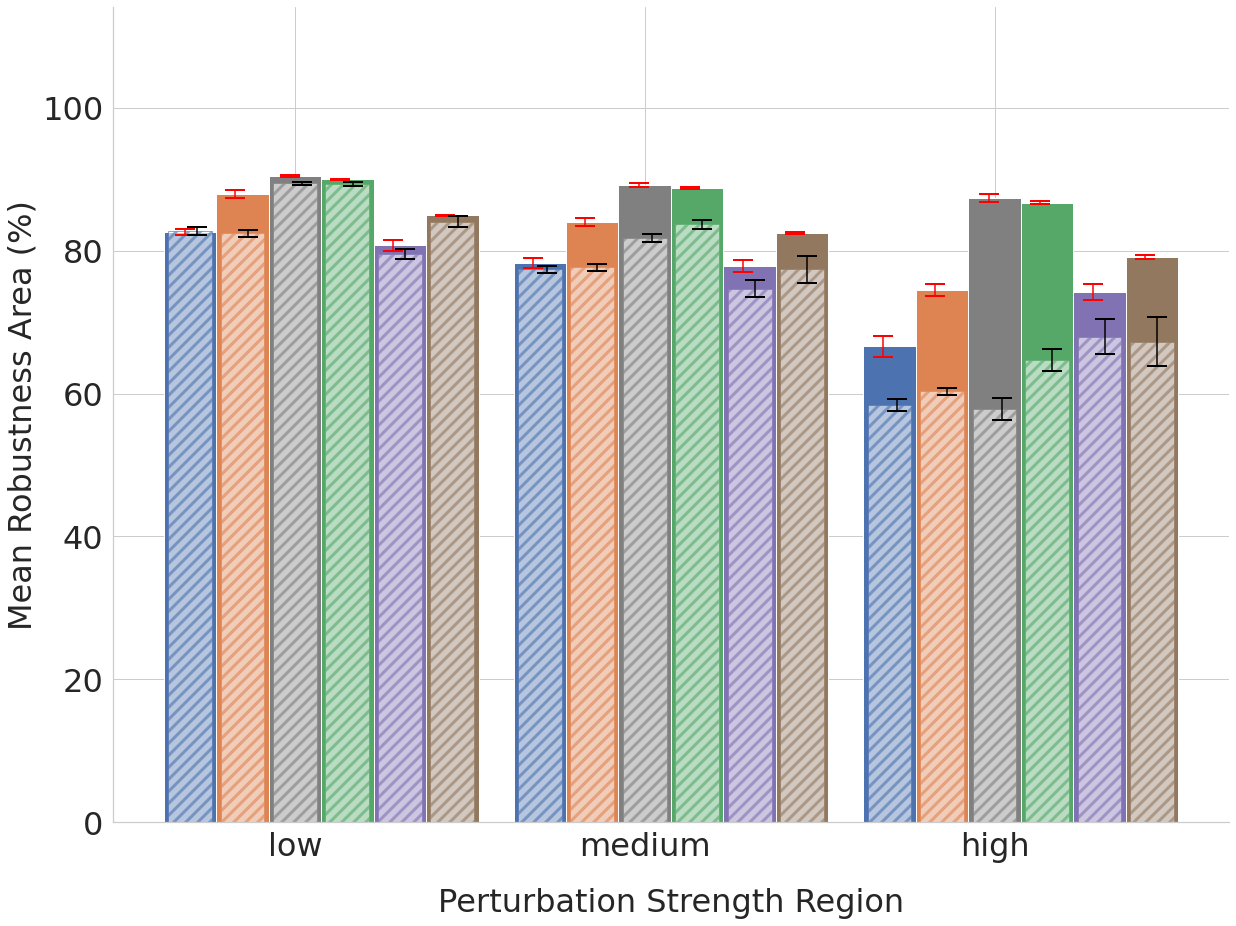

<Figure size 1080x1080 with 0 Axes>

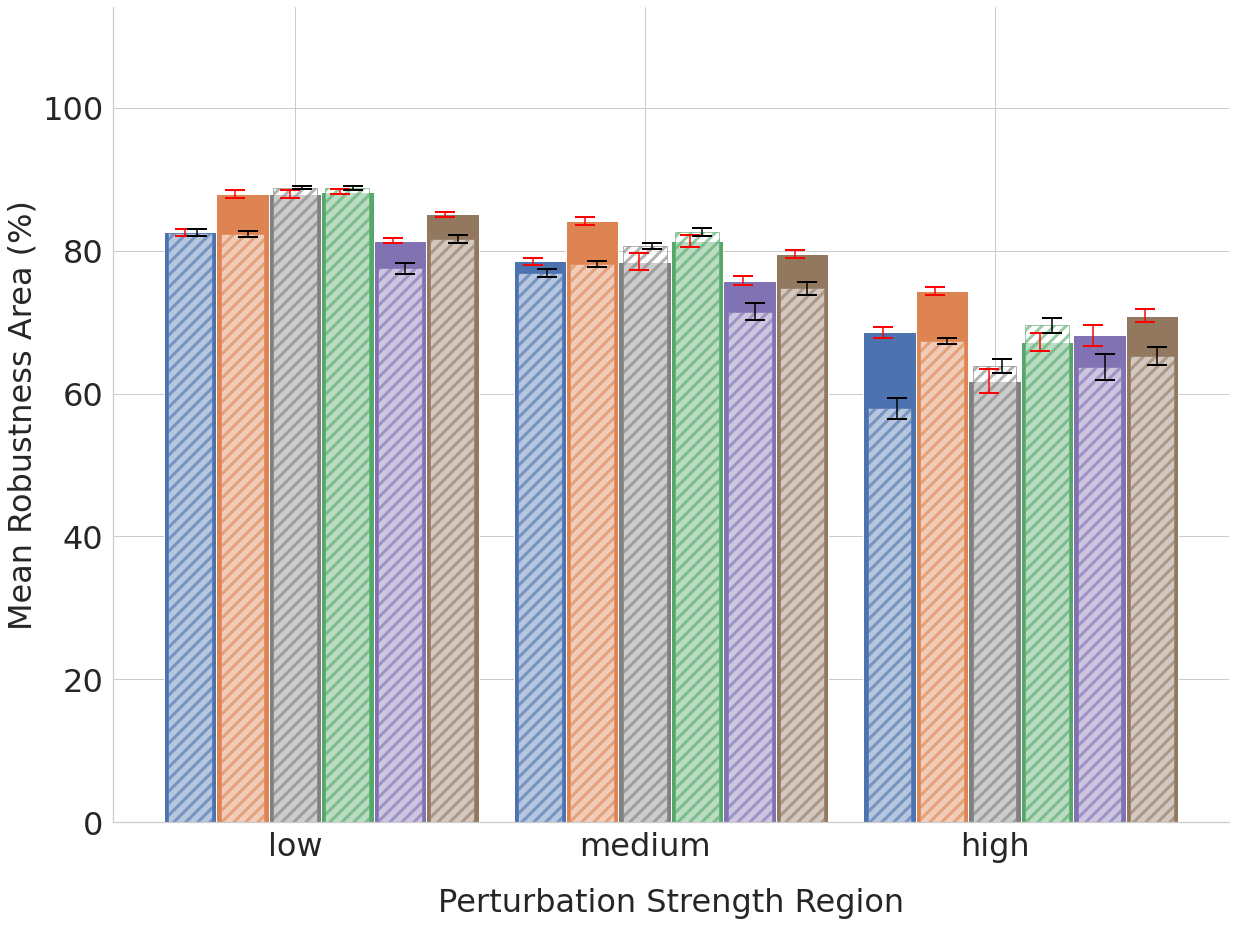

<Figure size 1080x1080 with 0 Axes>

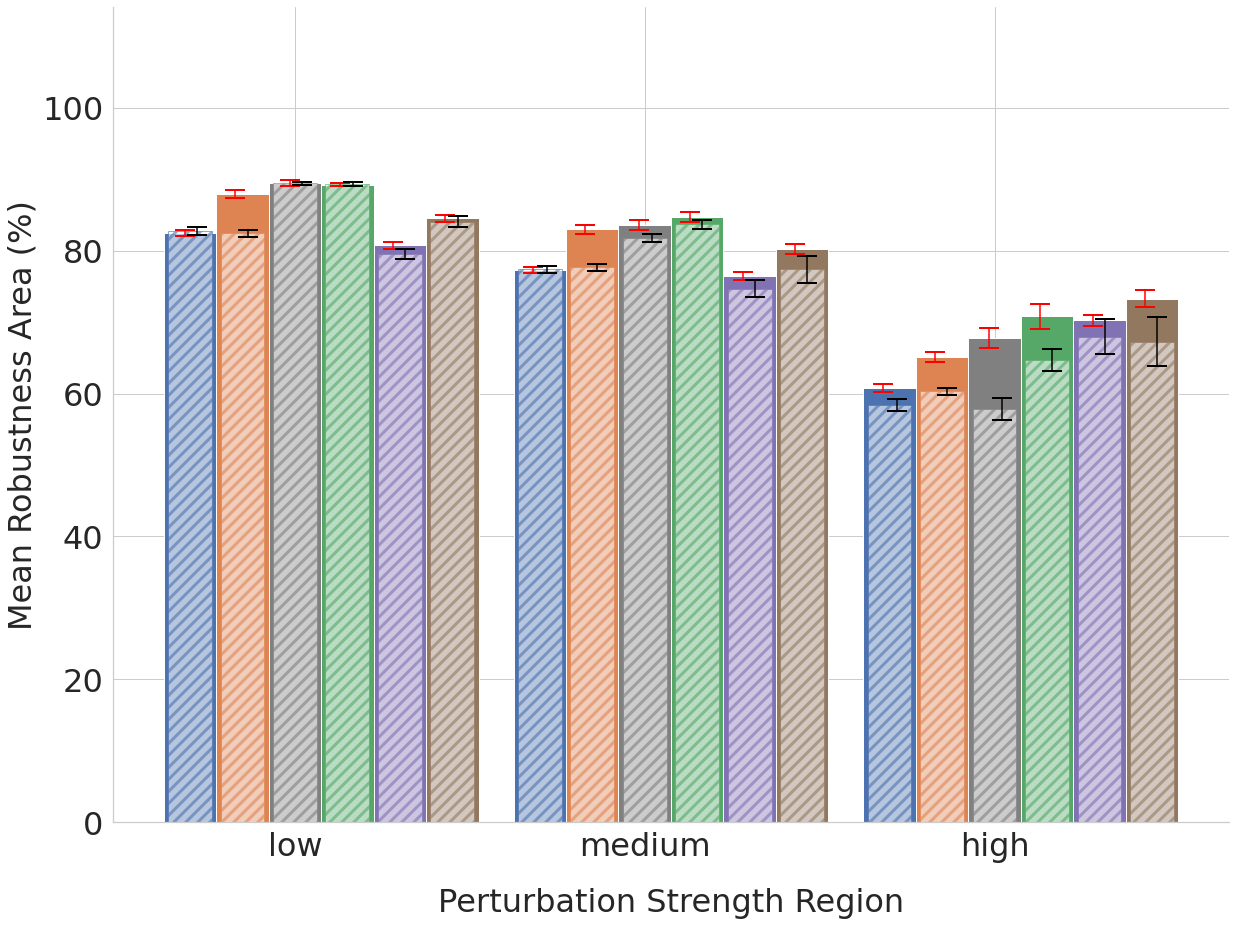

<Figure size 1080x1080 with 0 Axes>

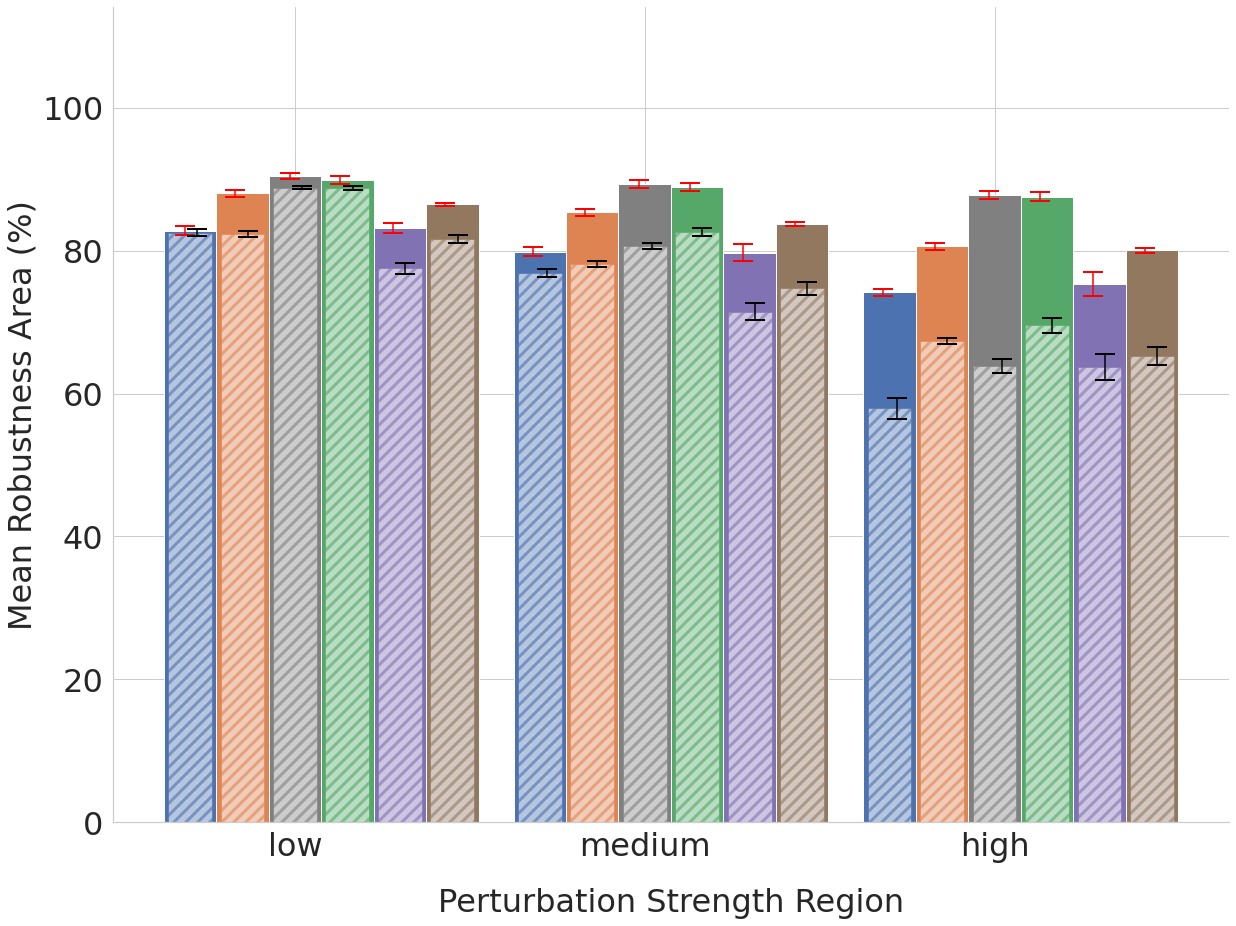

<Figure size 1080x1080 with 0 Axes>

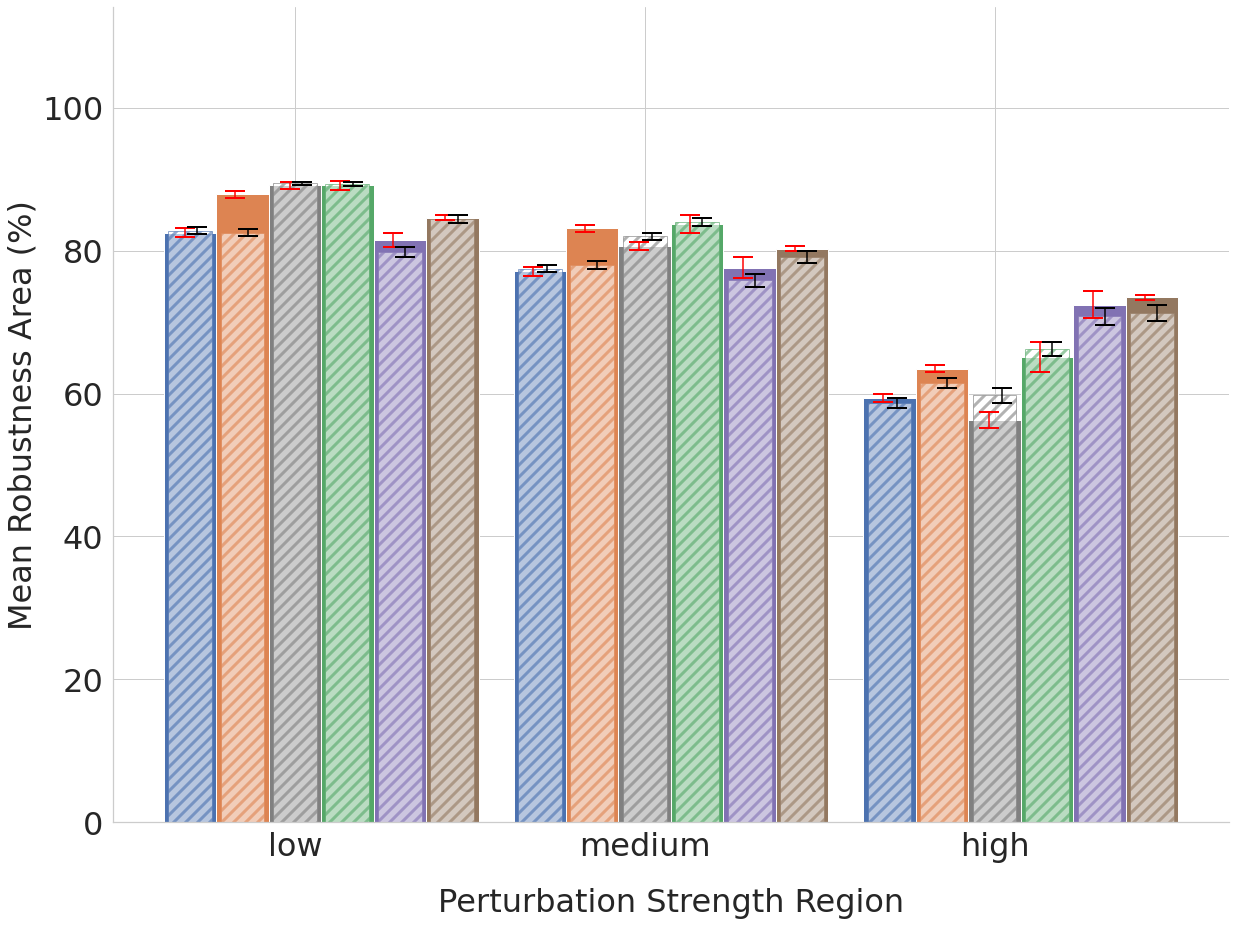

<Figure size 1080x1080 with 0 Axes>

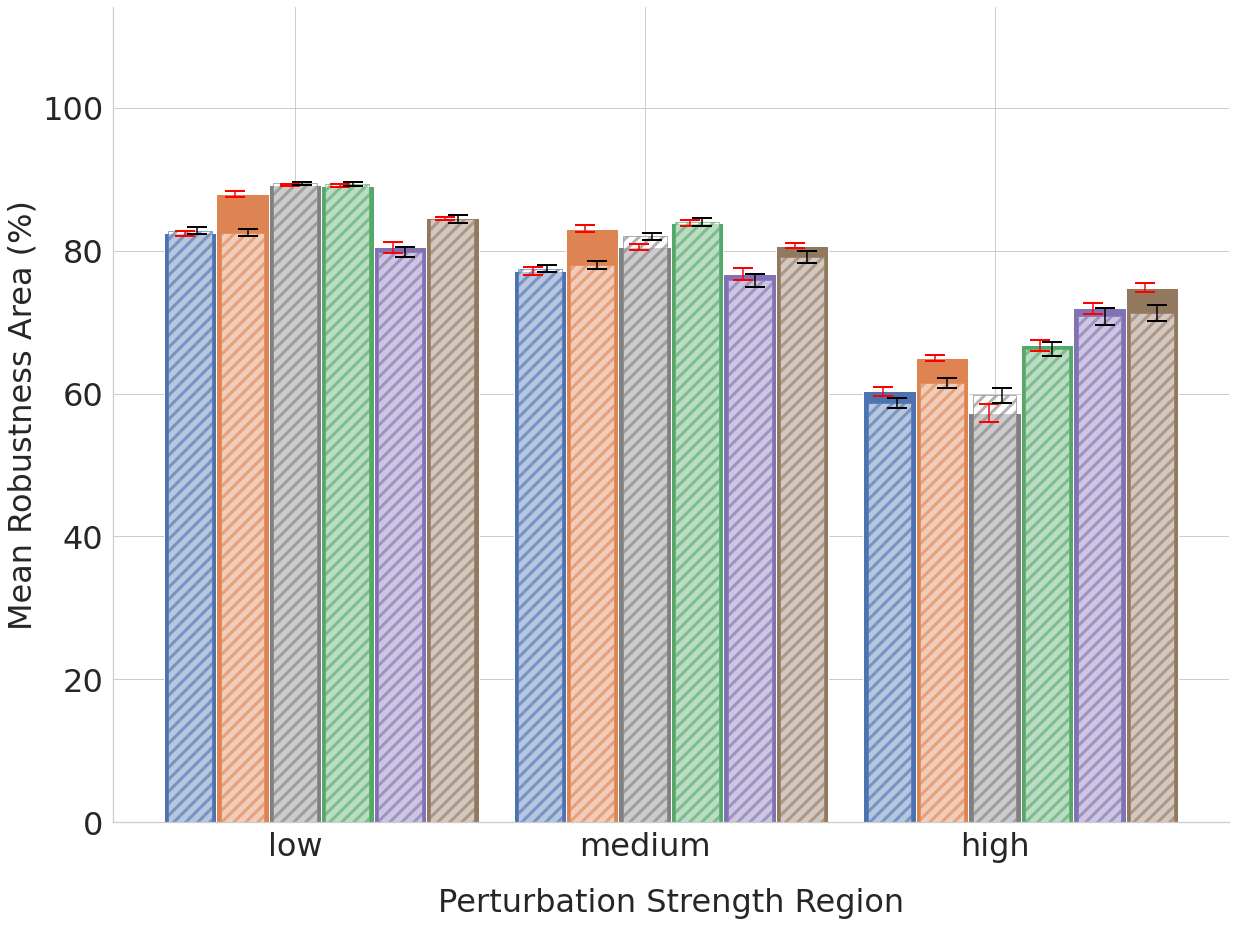

In [5]:
for i in range(len(augment_lst_perturbed_train)):
    
    augmented_idx = augment_lst_perturbed_train[i]
    attack_idx = attack_lst_perturbed_train[i]
    augmented = attack_lst[augmented_idx]
    attack = attack_lst[attack_idx]

    print("Figure 5"+ figure_lst[i])
    print("augmented:"+augmented)
    print("attack   :"+attack)

    sample_lst = [[5, 5, 5, 5],[10, 10, 5, 10],[5,5,5,5]]
    epoch_lst = [[5, 40, 20, 20], [20, 20, 20, 50], [10, 20, 20, 20]]
    transformer1024_epochs=[40, 50, 30, 20]

    filename = "results_unperturbed/df_results_lr_"+dataset.lower()+".pkl"
    [lr_vec, lr_vec_upper, lr_vec_lower, lr_vec_mean, lr_df] = results_vec_lr(attack, attack_lst, filename)

    filename = "results_unperturbed/results_unperturbed_svm_" + dataset + ".pkl"
    [svm_vec, svm_vec_upper, svm_vec_lower, svm_vec_mean, svm_df] = results_vec_lr(attack, attack_lst, filename)

    filename="results_unperturbed/perturbation_curve_samples_"+str(sample_lst[dataset_idx][0])+"_Transformer(128)_epoch_"+str(epoch_lst[dataset_idx][0])+"_"+dataset+"_"
    [tr128_vec, tr128_vec_upper, tr128_vec_lower, tr128_vec_mean, tr128_df] = results_vec(attack, attack_lst, filename)

    epoch = epoch_lst[dataset_idx][1]
    filename="results_unperturbed/perturbation_curve_samples_"+str(sample_lst[dataset_idx][1])+"_Transformer(1024)_epoch_"+str(epoch)+"_"+dataset+"_"
    [tr1024_vec, tr1024_vec_upper, tr1024_vec_lower, tr1024_vec_mean, tr1024_df] = results_vec(attack, attack_lst, filename)

    filename="results_unperturbed/perturbation_curve_samples_"+str(sample_lst[dataset_idx][2])+"_VDCNN(9)_epoch_"+str(epoch_lst[dataset_idx][2])+"_"+dataset+"_"
    [cnn9_vec, cnn9_vec_upper, cnn9_vec_lower, cnn9_vec_mean, cnn9_df] = results_vec(attack, attack_lst, filename)

    filename="results_unperturbed/perturbation_curve_samples_"+str(sample_lst[dataset_idx][3])+"_VDCNN(49)_epoch_"+str(epoch_lst[dataset_idx][3])+"_"+dataset+"_"
    [cnn49_vec, cnn49_vec_upper, cnn49_vec_lower, cnn49_vec_mean, cnn49_df] = results_vec(attack, attack_lst, filename)

    vec=[]
    if len(lr_vec_mean)>0:
        vec.append("$"+str(np.round(lr_vec_mean[0]*100,2))+" \pm "+str(np.round(lr_vec_mean[0]*100-lr_vec_lower[0]*100,2))+"$")
    else:
        vec.append("$"+str("???")+" \pm "+str("???")+"$")

    if len(lr_vec_mean)>0:
        vec.append("$"+str(np.round(svm_vec_mean[0]*100,2))+" \pm "+str(np.round(svm_vec_mean[0]*100-svm_vec_lower[0]*100,2))+"$")
    else:
        vec.append("$"+str("???")+" \pm "+str("???")+"$")

    if len(cnn9_vec_mean)>0:
        vec.append("$ "+str(np.round(cnn9_vec_mean[0]*100,2))+" \pm "+str(np.round(cnn9_vec_mean[0]*100-cnn9_vec_lower[0]*100,2))+"$")
    else:
        vec.append("$"+str("???")+" \pm "+str("???")+"$")
    if len(cnn49_vec_mean)>0:
        vec.append("$ "+str(np.round(cnn49_vec_mean[0]*100,2))+" \pm "+str(np.round(cnn49_vec_mean[0]*100-cnn49_vec_lower[0]*100,2))+"$")
    else:
        vec.append("$"+str("???")+" \pm "+str("???")+"$")
    if len(tr128_vec_mean)>0:
        vec.append("$ "+str(np.round(tr128_vec_mean[0]*100,2))+" \pm "+str(np.round(tr128_vec_mean[0]*100-tr128_vec_lower[0]*100,2))+"$")
    else:
        vec.append("$"+str("???")+" \pm "+str("???")+"$")

    if len(tr1024_vec_mean)>0:
        vec.append("$ "+str(np.round(tr1024_vec_mean[0]*100,2))+" \pm "+str(np.round(tr128_vec_mean[0]*100-tr1024_vec_lower[0]*100,2))+"$")
    else:
        vec.append("$ "+str("???")+" \pm "+str("???")+"$")

    df_latex_table['Model'] = ['\text{LR}', '\text{SVM}', '\text{CNN9}','\text{CNN49}','\text{TR128}','\text{TR1024}']
    df_latex_table[dataset] = vec

    vec=[str("???"),str(epoch_lst[dataset_idx][2]),str(epoch_lst[dataset_idx][3]),str(epoch_lst[dataset_idx][0]),str(epoch_lst[dataset_idx][1])]

    plt.rc('axes.spines', **{'bottom':True, 'left':True, 'right':False, 'top':False})

    df_integral_lr = return_area_dataframe(lr_df,attack,"LR")
    df_integral_svm = return_area_dataframe(svm_df,attack,"SVM")

    df_integral_tr128 = return_area_dataframe(tr128_df,attack,"TR(128)")
    df_integral_tr1024 = return_area_dataframe(tr1024_df,attack,"TR(1024)")

    df_integral_cnn9 = return_area_dataframe(cnn9_df,attack,"VDCNN(9)")
    df_integral_cnn49 = return_area_dataframe(cnn49_df,attack,"VDCNN(49)")

    df_integral_all = df_integral_lr.append(df_integral_tr128).append(df_integral_tr1024).append(df_integral_cnn9).append(df_integral_cnn49)
    df_integral_all = df_integral_all.reset_index().drop("index",axis=1)

    ###############################################################################################################
    df_integral_lr['mean integrated robustness'] = df_integral_lr['mean integrated robustness']/33.3*100
    df_integral_svm['mean integrated robustness'] = df_integral_svm['mean integrated robustness']/33.3*100
    df_integral_tr128['mean integrated robustness'] = df_integral_tr128['mean integrated robustness']/33.3*100
    df_integral_tr1024['mean integrated robustness'] = df_integral_tr1024['mean integrated robustness']/33.3*100
    df_integral_cnn9['mean integrated robustness'] = df_integral_cnn9['mean integrated robustness']/33.3*100
    df_integral_cnn49['mean integrated robustness'] = df_integral_cnn49['mean integrated robustness']/33.3*100
    ##############################################################################################################

    cat_seg = CategoricalDtype(
        ['low', 'medium', 'high'], 
        ordered=True
    )
    cat_model = CategoricalDtype(
        ['LR', "SVM", 'TR(128)','TR(1024)', 'VDCNN(9)','VDCNN(49)',], 
        ordered=True,
    )

    dfCopy = df_integral_all
    dfCopy['region'] = dfCopy['region'].astype(cat_seg)
    dfCopy['label'] = dfCopy['label'].astype(cat_model)
    dfCopy = dfCopy.sort_values(['region', 'label'])

    plt.rc('axes.spines', **{'bottom':True, 'left':True, 'right':False, 'top':False})

    plt.figure(figsize=(15,15))
    sns.set_theme(style="whitegrid")

    sample_lst = [[5, 5, 5, 5],[5, 5, 5, 5],[5,5,5,5]]
    epoch_lst = [[5, 40, 20, 20], [20, 20, 20, 50], [10, 20, 20, 20]]
    transformer1024_epochs=[40, 50, 30, 20]

    filename = "training_perturbed/training_"+augmented+"/df_results_lr_"+dataset.lower()+"_adv_50_50_"+augmented+".pkl"
    [lr_vec, lr_vec_upper, lr_vec_lower, lr_vec_mean, lr_df_perturbed] = results_vec_lr2(attack, attack_lst, filename)
    df_integral_lr_perturbed = return_area_dataframe(lr_df_perturbed,attack,"LR")
    ########################################################################################################
    filename = "training_perturbed/training_"+augmented+"/df_results_svm_"+dataset.lower()+"_adv_50_50_"+augmented+".pkl"
    [svm_vec, svm_vec_upper, svm_vec_lower, svm_vec_mean, svm_df_perturbed] = results_vec_lr2(attack, attack_lst, filename)
    df_integral_svm_perturbed = return_area_dataframe(svm_df_perturbed,attack,"SVM")
    ########################################################################################################
    filename="training_perturbed/training_"+augmented+"/perturbation_curve_samples_"+str(sample_lst[dataset_idx][0])+"_Transformer(128)_epoch_"+str(epoch_lst[dataset_idx][0])+"_"+dataset+"_"
    [tr128_vec, tr128_vec_upper, tr128_vec_lower, tr128_vec_mean, tr128_df_perturbed] = results_vec(attack, attack_lst, filename)
    df_integral_tr128_perturbed = return_area_dataframe(tr128_df_perturbed,attack,"TR(128)")
    ########################################################################################################
    filename="training_perturbed/training_"+augmented+"/perturbation_curve_samples_"+str(sample_lst[dataset_idx][1])+"_Transformer(1024)_epoch_"+str(epoch_lst[dataset_idx][1])+"_"+dataset+"_"
    [tr1024_vec, tr1024_vec_upper, tr1024_vec_lower, tr1024_vec_mean, tr1024_df_perturbed] = results_vec(attack, attack_lst, filename)
    df_integral_tr1024_perturbed = return_area_dataframe(tr1024_df_perturbed,attack,"TR(128)")
    ########################################################################################################
    filename="training_perturbed/training_"+augmented+"/perturbation_curve_samples_"+str(sample_lst[dataset_idx][2])+"_VDCNN(9)_epoch_"+str(epoch_lst[dataset_idx][2])+"_"+dataset+"_"
    [cnn9_vec, cnn9_vec_upper, cnn9_vec_lower, cnn9_vec_mean, cnn9_df_perturbed] = results_vec(attack, attack_lst, filename)
    df_integral_cnn9_perturbed = return_area_dataframe(cnn9_df_perturbed,attack,"VDCNN(9)")
    ########################################################################################################
    filename="training_perturbed/training_"+augmented+"/perturbation_curve_samples_"+str(sample_lst[dataset_idx][3])+"_VDCNN(49)_epoch_"+str(epoch_lst[dataset_idx][3])+"_"+dataset+"_"
    [cnn49_vec, cnn49_vec_upper, cnn49_vec_lower, cnn49_vec_mean, cnn49_df_perturbed] = results_vec(attack, attack_lst, filename)
    df_integral_cnn49_perturbed = return_area_dataframe(cnn49_df_perturbed,attack,"VDCNN(49)")
    ########################################################################################################

    ###############################################################################################
    df_integral_lr_perturbed['mean integrated robustness'] = df_integral_lr_perturbed['mean integrated robustness']/33.3*100
    df_integral_svm_perturbed['mean integrated robustness'] = df_integral_svm_perturbed['mean integrated robustness']/33.3*100
    df_integral_tr128_perturbed['mean integrated robustness'] = df_integral_tr128_perturbed['mean integrated robustness']/33.3*100
    df_integral_tr1024_perturbed['mean integrated robustness'] = df_integral_tr1024_perturbed['mean integrated robustness']/33.3*100
    df_integral_cnn9_perturbed['mean integrated robustness'] = df_integral_cnn9_perturbed['mean integrated robustness']/33.3*100
    df_integral_cnn49_perturbed['mean integrated robustness'] = df_integral_cnn49_perturbed['mean integrated robustness']/33.3*100
    ###############################################################################################

    ##############################################################################################################

    lr_perturbed=[]
    lr_perturbed.append(np.mean(df_integral_lr_perturbed[df_integral_lr_perturbed['region']=='low']['mean integrated robustness'].values))
    lr_perturbed.append(np.mean(df_integral_lr_perturbed[df_integral_lr_perturbed['region']=='medium']['mean integrated robustness'].values))
    lr_perturbed.append(np.mean(df_integral_lr_perturbed[df_integral_lr_perturbed['region']=='high']['mean integrated robustness'].values))
    error_lr_perturbed=[]
    error_lr_perturbed.append(sigma_factor*np.std(df_integral_lr_perturbed[df_integral_lr_perturbed['region']=='low']['mean integrated robustness'].values))
    error_lr_perturbed.append(sigma_factor*np.std(df_integral_lr_perturbed[df_integral_lr_perturbed['region']=='medium']['mean integrated robustness'].values))
    error_lr_perturbed.append(sigma_factor*np.std(df_integral_lr_perturbed[df_integral_lr_perturbed['region']=='high']['mean integrated robustness'].values))


    lr_unperturbed=[]
    lr_unperturbed.append(np.mean(df_integral_lr[df_integral_lr['region']=='low']['mean integrated robustness'].values))
    lr_unperturbed.append(np.mean(df_integral_lr[df_integral_lr['region']=='medium']['mean integrated robustness'].values))
    lr_unperturbed.append(np.mean(df_integral_lr[df_integral_lr['region']=='high']['mean integrated robustness'].values))
    error_lr_unperturbed=[]
    error_lr_unperturbed.append(sigma_factor*np.std(df_integral_lr[df_integral_lr['region']=='low']['mean integrated robustness'].values))
    error_lr_unperturbed.append(sigma_factor*np.std(df_integral_lr[df_integral_lr['region']=='medium']['mean integrated robustness'].values))
    error_lr_unperturbed.append(sigma_factor*np.std(df_integral_lr[df_integral_lr['region']=='high']['mean integrated robustness'].values))

    ##############################################################################################################

    svm_perturbed=[]
    svm_perturbed.append(np.mean(df_integral_svm_perturbed[df_integral_svm_perturbed['region']=='low']['mean integrated robustness'].values))
    svm_perturbed.append(np.mean(df_integral_svm_perturbed[df_integral_svm_perturbed['region']=='medium']['mean integrated robustness'].values))
    svm_perturbed.append(np.mean(df_integral_svm_perturbed[df_integral_svm_perturbed['region']=='high']['mean integrated robustness'].values))
    error_svm_perturbed=[]
    error_svm_perturbed.append(sigma_factor*np.std(df_integral_svm_perturbed[df_integral_svm_perturbed['region']=='low']['mean integrated robustness'].values))
    error_svm_perturbed.append(sigma_factor*np.std(df_integral_svm_perturbed[df_integral_svm_perturbed['region']=='medium']['mean integrated robustness'].values))
    error_svm_perturbed.append(sigma_factor*np.std(df_integral_svm_perturbed[df_integral_svm_perturbed['region']=='high']['mean integrated robustness'].values))


    svm_unperturbed=[]
    svm_unperturbed.append(np.mean(df_integral_svm[df_integral_svm['region']=='low']['mean integrated robustness'].values))
    svm_unperturbed.append(np.mean(df_integral_svm[df_integral_svm['region']=='medium']['mean integrated robustness'].values))
    svm_unperturbed.append(np.mean(df_integral_svm[df_integral_svm['region']=='high']['mean integrated robustness'].values))
    error_svm_unperturbed=[]
    error_svm_unperturbed.append(sigma_factor*np.std(df_integral_svm[df_integral_svm['region']=='low']['mean integrated robustness'].values))
    error_svm_unperturbed.append(sigma_factor*np.std(df_integral_svm[df_integral_svm['region']=='medium']['mean integrated robustness'].values))
    error_svm_unperturbed.append(sigma_factor*np.std(df_integral_svm[df_integral_svm['region']=='high']['mean integrated robustness'].values))

    ##############################################################################################################

    tr128_perturbed=[]
    tr128_perturbed.append(np.mean(df_integral_tr128_perturbed[df_integral_tr128_perturbed['region']=='low']['mean integrated robustness'].values))
    tr128_perturbed.append(np.mean(df_integral_tr128_perturbed[df_integral_tr128_perturbed['region']=='medium']['mean integrated robustness'].values))
    tr128_perturbed.append(np.mean(df_integral_tr128_perturbed[df_integral_tr128_perturbed['region']=='high']['mean integrated robustness'].values))
    error_tr128_perturbed=[]
    error_tr128_perturbed.append(np.std(df_integral_tr128_perturbed[df_integral_tr128_perturbed['region']=='low']['mean integrated robustness'].values))
    error_tr128_perturbed.append(np.std(df_integral_tr128_perturbed[df_integral_tr128_perturbed['region']=='medium']['mean integrated robustness'].values))
    error_tr128_perturbed.append(np.std(df_integral_tr128_perturbed[df_integral_tr128_perturbed['region']=='high']['mean integrated robustness'].values))


    tr128_unperturbed=[]
    tr128_unperturbed.append(np.mean(df_integral_tr128[df_integral_tr128['region']=='low']['mean integrated robustness'].values))
    tr128_unperturbed.append(np.mean(df_integral_tr128[df_integral_tr128['region']=='medium']['mean integrated robustness'].values))
    tr128_unperturbed.append(np.mean(df_integral_tr128[df_integral_tr128['region']=='high']['mean integrated robustness'].values))
    error_tr128_unperturbed=[]
    error_tr128_unperturbed.append(np.std(df_integral_tr128[df_integral_tr128['region']=='low']['mean integrated robustness'].values))
    error_tr128_unperturbed.append(np.std(df_integral_tr128[df_integral_tr128['region']=='medium']['mean integrated robustness'].values))
    error_tr128_unperturbed.append(np.std(df_integral_tr128[df_integral_tr128['region']=='high']['mean integrated robustness'].values))

    ##############################################################################################################

    tr1024_perturbed=[]
    tr1024_perturbed.append(np.mean(df_integral_tr1024_perturbed[df_integral_tr1024_perturbed['region']=='low']['mean integrated robustness'].values))
    tr1024_perturbed.append(np.mean(df_integral_tr1024_perturbed[df_integral_tr1024_perturbed['region']=='medium']['mean integrated robustness'].values))
    tr1024_perturbed.append(np.mean(df_integral_tr1024_perturbed[df_integral_tr1024_perturbed['region']=='high']['mean integrated robustness'].values))
    error_tr1024_perturbed=[]
    error_tr1024_perturbed.append(np.std(df_integral_tr1024_perturbed[df_integral_tr1024_perturbed['region']=='low']['mean integrated robustness'].values))
    error_tr1024_perturbed.append(np.std(df_integral_tr1024_perturbed[df_integral_tr1024_perturbed['region']=='medium']['mean integrated robustness'].values))
    error_tr1024_perturbed.append(np.std(df_integral_tr1024_perturbed[df_integral_tr1024_perturbed['region']=='high']['mean integrated robustness'].values))


    tr1024_unperturbed=[]
    tr1024_unperturbed.append(np.mean(df_integral_tr1024[df_integral_tr1024['region']=='low']['mean integrated robustness'].values))
    tr1024_unperturbed.append(np.mean(df_integral_tr1024[df_integral_tr1024['region']=='medium']['mean integrated robustness'].values))
    tr1024_unperturbed.append(np.mean(df_integral_tr1024[df_integral_tr1024['region']=='high']['mean integrated robustness'].values))
    error_tr1024_unperturbed=[]
    error_tr1024_unperturbed.append(np.std(df_integral_tr1024[df_integral_tr1024['region']=='low']['mean integrated robustness'].values))
    error_tr1024_unperturbed.append(np.std(df_integral_tr1024[df_integral_tr1024['region']=='medium']['mean integrated robustness'].values))
    error_tr1024_unperturbed.append(np.std(df_integral_tr1024[df_integral_tr1024['region']=='high']['mean integrated robustness'].values))

    #################################################################################################################

    cnn9_perturbed=[]
    cnn9_perturbed.append(np.mean(df_integral_cnn9_perturbed[df_integral_cnn9_perturbed['region']=='low']['mean integrated robustness'].values))
    cnn9_perturbed.append(np.mean(df_integral_cnn9_perturbed[df_integral_cnn9_perturbed['region']=='medium']['mean integrated robustness'].values))
    cnn9_perturbed.append(np.mean(df_integral_cnn9_perturbed[df_integral_cnn9_perturbed['region']=='high']['mean integrated robustness'].values))
    error_cnn9_perturbed=[]
    error_cnn9_perturbed.append(np.std(df_integral_cnn9_perturbed[df_integral_cnn9_perturbed['region']=='low']['mean integrated robustness'].values))
    error_cnn9_perturbed.append(np.std(df_integral_cnn9_perturbed[df_integral_cnn9_perturbed['region']=='medium']['mean integrated robustness'].values))
    error_cnn9_perturbed.append(np.std(df_integral_cnn9_perturbed[df_integral_cnn9_perturbed['region']=='high']['mean integrated robustness'].values))


    cnn9_unperturbed=[]
    cnn9_unperturbed.append(np.mean(df_integral_cnn9[df_integral_cnn9['region']=='low']['mean integrated robustness'].values))
    cnn9_unperturbed.append(np.mean(df_integral_cnn9[df_integral_cnn9['region']=='medium']['mean integrated robustness'].values))
    cnn9_unperturbed.append(np.mean(df_integral_cnn9[df_integral_cnn9['region']=='high']['mean integrated robustness'].values))
    error_cnn9_unperturbed=[]
    error_cnn9_unperturbed.append(np.std(df_integral_cnn9[df_integral_cnn9['region']=='low']['mean integrated robustness'].values))
    error_cnn9_unperturbed.append(np.std(df_integral_cnn9[df_integral_cnn9['region']=='medium']['mean integrated robustness'].values))
    error_cnn9_unperturbed.append(np.std(df_integral_cnn9[df_integral_cnn9['region']=='high']['mean integrated robustness'].values))

    #################################################################################################################

    cnn49_perturbed=[]
    cnn49_perturbed.append(np.mean(df_integral_cnn49_perturbed[df_integral_cnn49_perturbed['region']=='low']['mean integrated robustness'].values))
    cnn49_perturbed.append(np.mean(df_integral_cnn49_perturbed[df_integral_cnn49_perturbed['region']=='medium']['mean integrated robustness'].values))
    cnn49_perturbed.append(np.mean(df_integral_cnn49_perturbed[df_integral_cnn49_perturbed['region']=='high']['mean integrated robustness'].values))
    error_cnn49_perturbed=[]
    error_cnn49_perturbed.append(np.std(df_integral_cnn49_perturbed[df_integral_cnn49_perturbed['region']=='low']['mean integrated robustness'].values))
    error_cnn49_perturbed.append(np.std(df_integral_cnn49_perturbed[df_integral_cnn49_perturbed['region']=='medium']['mean integrated robustness'].values))
    error_cnn49_perturbed.append(np.std(df_integral_cnn49_perturbed[df_integral_cnn49_perturbed['region']=='high']['mean integrated robustness'].values))


    cnn49_unperturbed=[]
    cnn49_unperturbed.append(np.mean(df_integral_cnn49[df_integral_cnn49['region']=='low']['mean integrated robustness'].values))
    cnn49_unperturbed.append(np.mean(df_integral_cnn49[df_integral_cnn49['region']=='medium']['mean integrated robustness'].values))
    cnn49_unperturbed.append(np.mean(df_integral_cnn49[df_integral_cnn49['region']=='high']['mean integrated robustness'].values))
    error_cnn49_unperturbed=[]
    error_cnn49_unperturbed.append(np.std(df_integral_cnn49[df_integral_cnn49['region']=='low']['mean integrated robustness'].values))
    error_cnn49_unperturbed.append(np.std(df_integral_cnn49[df_integral_cnn49['region']=='medium']['mean integrated robustness'].values))
    error_cnn49_unperturbed.append(np.std(df_integral_cnn49[df_integral_cnn49['region']=='high']['mean integrated robustness'].values))

    #################################################################################################################

    plt.rc('axes.spines', **{'bottom':True, 'left':True, 'right':False, 'top':False})
    ax = plt.figure(figsize=(20,15))
    sns.set_theme(style="whitegrid")

    first_bar_positions = np.arange(len(lr_unperturbed))
    second_bar_positions = first_bar_positions + bar_width
    third_bar_positions = first_bar_positions + 2*bar_width
    forth_bar_positions = first_bar_positions + 3*bar_width
    fifth_bar_positions = first_bar_positions + 4*bar_width
    sixth_bar_positions = first_bar_positions + 5*bar_width

    ################################################################################################################
    # make bar plots
    lr_perturbed_bar = plt.bar(first_bar_positions, lr_perturbed, bar_width,
                                 ecolor='black', alpha=opacity2,
                              capsize=cap, color='#4c72b0',
                              label='LR perturbed')

    lr_unperturbed_bar = plt.bar(first_bar_positions, lr_unperturbed, bar_width-epsilon,
                               ecolor='red', capsize=cap2,
                              alpha=opacity,
                              color='white',
                              edgecolor='#4c72b0',
                              linewidth=line_width,
                              hatch='//',
                              label='LR unperturbed')

    plt.errorbar(-0.015, lr_perturbed[0], yerr=error_lr_perturbed[0], capsize=cap, color = "red", 
                 capthick = cap_thick, ls = '--')
    plt.errorbar(0.02, lr_unperturbed[0], yerr=error_lr_unperturbed[0], capsize=cap, color = "black", 
                 capthick = cap_thick)
    plt.errorbar(0.98, lr_perturbed[1], yerr=error_lr_perturbed[1], capsize=cap, color = "red", capthick = cap_thick)
    plt.errorbar(1.02, lr_unperturbed[1], yerr=error_lr_unperturbed[1], capsize=cap, color = "black", capthick = cap_thick)
    plt.errorbar(1.98, lr_perturbed[2], yerr=error_lr_perturbed[2], capsize=cap, color = "red", capthick = cap_thick)
    plt.errorbar(2.02, lr_unperturbed[2], yerr=error_lr_unperturbed[2], capsize=cap, color = "black", capthick = cap_thick)


    ################################################################################################################
    # make bar plots
    svm_perturbed_bar = plt.bar(second_bar_positions, svm_perturbed, bar_width,
                                 ecolor='black', alpha=opacity2,
                              capsize=cap, color='#dd8452',
                              label='SVM perturbed')

    svm_unperturbed_bar = plt.bar(second_bar_positions, svm_unperturbed, bar_width-epsilon,
                               ecolor='red', capsize=cap2,
                              alpha=opacity,
                              color='white',
                              edgecolor='#dd8452',
                              linewidth=line_width,
                              hatch='//',
                              label='SVM unperturbed')

    plt.errorbar(0.13, svm_perturbed[0], yerr=error_svm_perturbed[0], capsize=cap, color = "red", 
                 capthick = cap_thick, ls = '--')
    plt.errorbar(0.165, svm_unperturbed[0], yerr=error_svm_unperturbed[0], capsize=cap, color = "black", 
                 capthick = cap_thick)
    plt.errorbar(1.13, svm_perturbed[1], yerr=error_svm_perturbed[1], capsize=cap, color = "red", capthick = cap_thick)
    plt.errorbar(1.165, svm_unperturbed[1], yerr=error_svm_unperturbed[1], capsize=cap, color = "black", capthick = cap_thick)
    plt.errorbar(2.13, svm_perturbed[2], yerr=error_svm_perturbed[2], capsize=cap, color = "red", capthick = cap_thick)
    plt.errorbar(2.165, svm_unperturbed[2], yerr=error_svm_unperturbed[2], capsize=cap, color = "black", capthick = cap_thick)

    ##################################################################################################################

    tr128_perturbed_bar = plt.bar(third_bar_positions, tr128_perturbed, bar_width, 
                                  ecolor='black',
                              capsize=cap, color='grey',
                              label='TR(128) perturbed')

    tr128_unperturbed_bar = plt.bar(third_bar_positions, tr128_unperturbed, bar_width-epsilon, 
                                  ecolor='red',
                                  capsize=cap2,
                                  alpha=opacity,
                                  color='white',
                                  edgecolor='grey',
                                  linewidth=line_width,
                                  hatch='//',
                                  label='TR(128) unperturbed')

    plt.errorbar(0.285, tr128_perturbed[0], yerr=error_tr128_perturbed[0], capsize=cap, color = "red", 
                 capthick = cap_thick, ls = '--')
    plt.errorbar(0.32, tr128_unperturbed[0], yerr=error_tr128_unperturbed[0], capsize=cap, color = "black", 
                 capthick = cap_thick)
    plt.errorbar(1.285, tr128_perturbed[1], yerr=error_tr128_perturbed[1], capsize=cap, color = "red", capthick = cap_thick)
    plt.errorbar(1.32, tr128_unperturbed[1], yerr=error_tr128_unperturbed[1], capsize=cap, color = "black", capthick = cap_thick)
    plt.errorbar(2.285, tr128_perturbed[2], yerr=error_tr128_perturbed[2], capsize=cap, color = "red", capthick = cap_thick)
    plt.errorbar(2.32, tr128_unperturbed[2], yerr=error_tr128_unperturbed[2], capsize=cap, color = "black", capthick = cap_thick)

    ##################################################################################################################

    tr1024_perturbed_bar = plt.bar(forth_bar_positions, tr1024_perturbed, bar_width, 
                            ecolor='black',capsize=cap, color='#55a868',label='TR(1024) perturbed')

    tr1024_unperturbed_bar = plt.bar(forth_bar_positions, tr1024_unperturbed, bar_width-epsilon, 
                              ecolor='red',
                              capsize=cap2,
                              alpha=opacity,
                              color='white',
                              edgecolor='#55a868',
                              linewidth=line_width,
                              hatch='//',
                              label='TR(1024) unperturbed')

    plt.errorbar(0.43, tr1024_perturbed[0], yerr=error_tr1024_perturbed[0], capsize=cap, color = "red", 
                 capthick = cap_thick, ls = '--')
    plt.errorbar(0.465, tr1024_unperturbed[0], yerr=error_tr1024_unperturbed[0], capsize=cap, color = "black", 
                 capthick = cap_thick)
    plt.errorbar(1.43, tr1024_perturbed[1], yerr=error_tr1024_perturbed[1], capsize=cap, color = "red", capthick = cap_thick)
    plt.errorbar(1.465, tr1024_unperturbed[1], yerr=error_tr1024_unperturbed[1], capsize=cap, color = "black", capthick = cap_thick)
    plt.errorbar(2.43, tr1024_perturbed[2], yerr=error_tr1024_perturbed[2], capsize=cap, color = "red", capthick = cap_thick)
    plt.errorbar(2.465, tr1024_unperturbed[2], yerr=error_tr1024_unperturbed[2], capsize=cap, color = "black", capthick = cap_thick)


    #################################################################################################################

    cnn9_perturbed_bar = plt.bar(fifth_bar_positions, cnn9_perturbed, bar_width, ecolor='black',
                              capsize=cap, color='#8172b3',
                              label='VDCNN(9) perturbed')

    cnn9_unperturbed_bar = plt.bar(fifth_bar_positions, cnn9_unperturbed, bar_width-epsilon,
                              ecolor='red',
                              capsize=cap2,
                              alpha=opacity,
                              color='white',
                              edgecolor='#8172b3',
                              linewidth=line_width,
                              hatch='//',
                              label='VDCNN(9) unperturbed')

    plt.errorbar(0.58, cnn9_perturbed[0], yerr=error_cnn9_perturbed[0], 
                 capsize=cap, color = "red", capthick = cap_thick, ls = '--')
    plt.errorbar(0.615, cnn9_unperturbed[0], yerr=error_cnn9_unperturbed[0], 
                 capsize=cap, color = "black", capthick = cap_thick)
    plt.errorbar(1.58, cnn9_perturbed[1], yerr=error_cnn9_perturbed[1], capsize=cap, 
                 color = "red", capthick = cap_thick)
    plt.errorbar(1.615, cnn9_unperturbed[1], yerr=error_cnn9_unperturbed[1], capsize=cap, 
                 color = "black", capthick = cap_thick)
    plt.errorbar(2.58, cnn9_perturbed[2], yerr=error_cnn9_perturbed[2], capsize=cap, color = "red",
                 capthick = cap_thick)
    plt.errorbar(2.615, cnn9_unperturbed[2], yerr=error_cnn9_unperturbed[2], 
                 capsize=cap, color = "black", capthick = cap_thick)



    ################################################################################################################

    cnn49_perturbed_bar = plt.bar(sixth_bar_positions, cnn49_perturbed, bar_width, 
                            ecolor='black',color='#937860',label='VDCNN(49) perturbed')

    cnn49_unperturbed_bar = plt.bar(sixth_bar_positions, cnn49_unperturbed, bar_width-epsilon, 
                              ecolor='red',
                              alpha=opacity,
                              color='white',
                              edgecolor='#937860',
                              linewidth=line_width,
                              hatch='//',
                              label='VDCNN(49) unperturbed')

    plt.errorbar(0.73, cnn49_perturbed[0], yerr=error_cnn49_perturbed[0], color = "red",capsize=cap, capthick = cap_thick)
    plt.errorbar(0.765, cnn49_unperturbed[0], yerr=error_cnn49_unperturbed[0], color = "black",capsize=cap, capthick = cap_thick)
    plt.errorbar(1.73, cnn49_perturbed[1], yerr=error_cnn49_perturbed[1], color = "red",capsize=cap, capthick = cap_thick)
    plt.errorbar(1.765, cnn49_unperturbed[1], yerr=error_cnn49_unperturbed[1], color = "black",capsize=cap, capthick = cap_thick)
    plt.errorbar(2.73, cnn49_perturbed[2], yerr=error_cnn49_perturbed[2], color = "red",capsize=cap, capthick = cap_thick)
    plt.errorbar(2.765, cnn49_unperturbed[2], yerr=error_cnn49_unperturbed[2], color = "black",capsize=cap, capthick = cap_thick)


    categories = ["unperturbed", "perturbed"]

    p5, = plot([0], marker='None',
               linestyle='None', label='dummy-tophead')

    plt.xticks(third_bar_positions, segments, fontsize = font_size)
    plt.ylabel('Mean Robustness Area (%)', fontsize = font_size)
    plt.xlabel('Perturbation Strength Region', fontsize = font_size, labelpad=25)
    plt.yticks(fontsize = font_size)
    plt.ylim([0, 38/33.3*100])

    sns.despine()
    ax.set_rasterized(True)
    
    plt.savefig(path3 +figure_lst[i] + "_" + dataset+"_robustness_train_"+augmented+"_test_"+attack+".eps", 
                bbox_inches='tight', format = "eps", rasterized=True)
    plt.savefig(path4 +figure_lst[i] + "_" + dataset+"_robustness_train_"+augmented+"_test_"+attack+".png", bbox_inches='tight', dpi = 300)


Figure 5a
augmented:SimilarSymbols
attack   :SimilarSymbols


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

<Figure size 1080x1080 with 0 Axes>

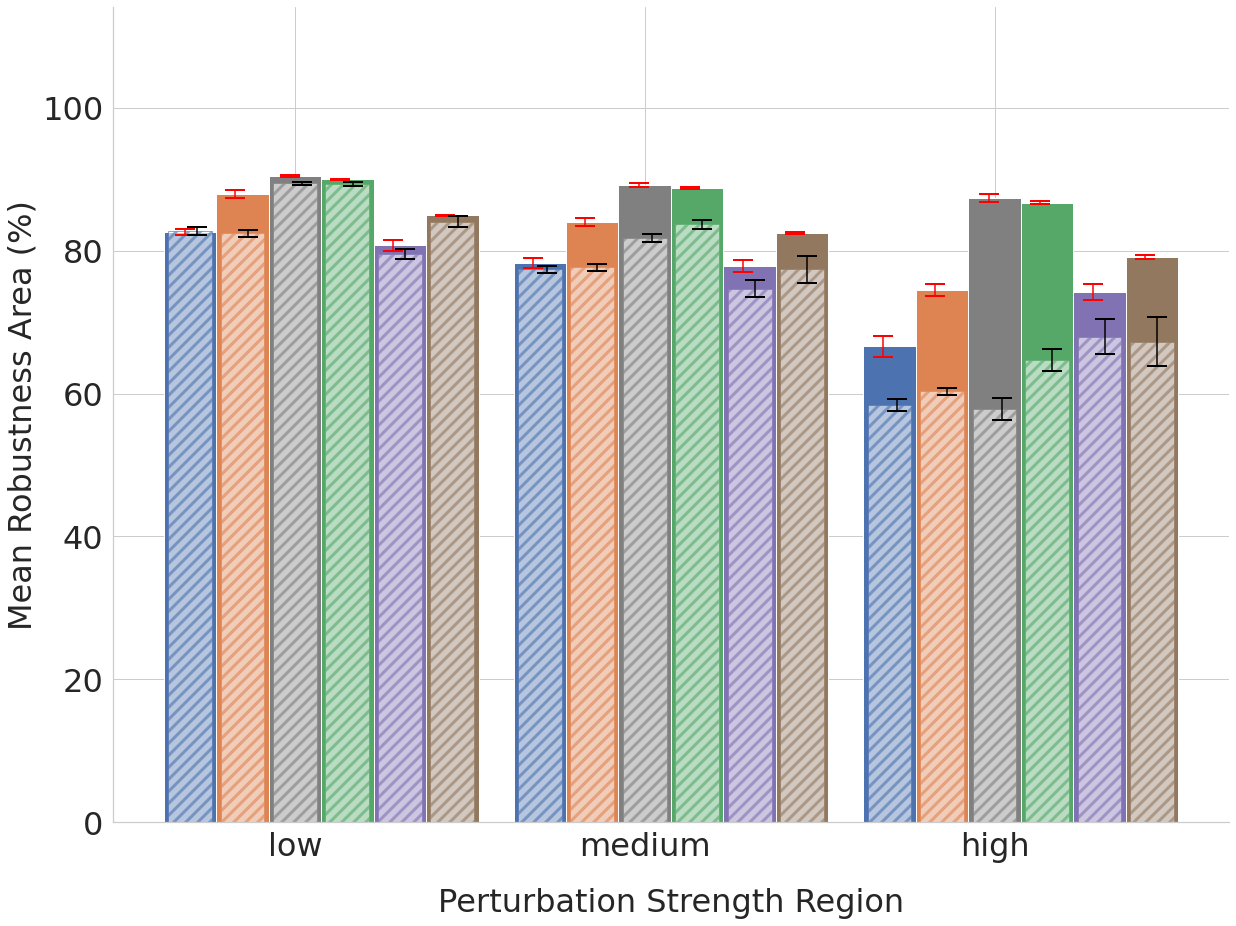

In [6]:
i = 0
augmented_idx = augment_lst_perturbed_train[i]
attack_idx = attack_lst_perturbed_train[i]
augmented = attack_lst[augmented_idx]
attack = attack_lst[attack_idx]

print("Figure 5"+ figure_lst[i])
print("augmented:"+augmented)
print("attack   :"+attack)

sample_lst = [[5, 5, 5, 5],[10, 10, 5, 10],[5,5,5,5]]
epoch_lst = [[5, 40, 20, 20], [20, 20, 20, 50], [10, 20, 20, 20]]
transformer1024_epochs=[40, 50, 30, 20]

filename = "results_unperturbed/df_results_lr_"+dataset.lower()+".pkl"
[lr_vec, lr_vec_upper, lr_vec_lower, lr_vec_mean, lr_df] = results_vec_lr(attack, attack_lst, filename)

filename = "results_unperturbed/results_unperturbed_svm_" + dataset + ".pkl"
[svm_vec, svm_vec_upper, svm_vec_lower, svm_vec_mean, svm_df] = results_vec_lr(attack, attack_lst, filename)

filename="results_unperturbed/perturbation_curve_samples_"+str(sample_lst[dataset_idx][0])+"_Transformer(128)_epoch_"+str(epoch_lst[dataset_idx][0])+"_"+dataset+"_"
[tr128_vec, tr128_vec_upper, tr128_vec_lower, tr128_vec_mean, tr128_df] = results_vec(attack, attack_lst, filename)

epoch = epoch_lst[dataset_idx][1]
filename="results_unperturbed/perturbation_curve_samples_"+str(sample_lst[dataset_idx][1])+"_Transformer(1024)_epoch_"+str(epoch)+"_"+dataset+"_"
[tr1024_vec, tr1024_vec_upper, tr1024_vec_lower, tr1024_vec_mean, tr1024_df] = results_vec(attack, attack_lst, filename)

filename="results_unperturbed/perturbation_curve_samples_"+str(sample_lst[dataset_idx][2])+"_VDCNN(9)_epoch_"+str(epoch_lst[dataset_idx][2])+"_"+dataset+"_"
[cnn9_vec, cnn9_vec_upper, cnn9_vec_lower, cnn9_vec_mean, cnn9_df] = results_vec(attack, attack_lst, filename)

filename="results_unperturbed/perturbation_curve_samples_"+str(sample_lst[dataset_idx][3])+"_VDCNN(49)_epoch_"+str(epoch_lst[dataset_idx][3])+"_"+dataset+"_"
[cnn49_vec, cnn49_vec_upper, cnn49_vec_lower, cnn49_vec_mean, cnn49_df] = results_vec(attack, attack_lst, filename)

vec=[]
if len(lr_vec_mean)>0:
    vec.append("$"+str(np.round(lr_vec_mean[0]*100,2))+" \pm "+str(np.round(lr_vec_mean[0]*100-lr_vec_lower[0]*100,2))+"$")
else:
    vec.append("$"+str("???")+" \pm "+str("???")+"$")

if len(lr_vec_mean)>0:
    vec.append("$"+str(np.round(svm_vec_mean[0]*100,2))+" \pm "+str(np.round(svm_vec_mean[0]*100-svm_vec_lower[0]*100,2))+"$")
else:
    vec.append("$"+str("???")+" \pm "+str("???")+"$")

if len(cnn9_vec_mean)>0:
    vec.append("$ "+str(np.round(cnn9_vec_mean[0]*100,2))+" \pm "+str(np.round(cnn9_vec_mean[0]*100-cnn9_vec_lower[0]*100,2))+"$")
else:
    vec.append("$"+str("???")+" \pm "+str("???")+"$")
if len(cnn49_vec_mean)>0:
    vec.append("$ "+str(np.round(cnn49_vec_mean[0]*100,2))+" \pm "+str(np.round(cnn49_vec_mean[0]*100-cnn49_vec_lower[0]*100,2))+"$")
else:
    vec.append("$"+str("???")+" \pm "+str("???")+"$")
if len(tr128_vec_mean)>0:
    vec.append("$ "+str(np.round(tr128_vec_mean[0]*100,2))+" \pm "+str(np.round(tr128_vec_mean[0]*100-tr128_vec_lower[0]*100,2))+"$")
else:
    vec.append("$"+str("???")+" \pm "+str("???")+"$")

if len(tr1024_vec_mean)>0:
    vec.append("$ "+str(np.round(tr1024_vec_mean[0]*100,2))+" \pm "+str(np.round(tr128_vec_mean[0]*100-tr1024_vec_lower[0]*100,2))+"$")
else:
    vec.append("$ "+str("???")+" \pm "+str("???")+"$")

df_latex_table['Model'] = ['\text{LR}', '\text{SVM}', '\text{CNN9}','\text{CNN49}','\text{TR128}','\text{TR1024}']
df_latex_table[dataset] = vec

vec=[str("???"),str(epoch_lst[dataset_idx][2]),str(epoch_lst[dataset_idx][3]),str(epoch_lst[dataset_idx][0]),str(epoch_lst[dataset_idx][1])]

plt.rc('axes.spines', **{'bottom':True, 'left':True, 'right':False, 'top':False})

df_integral_lr = return_area_dataframe(lr_df,attack,"LR")
df_integral_svm = return_area_dataframe(svm_df,attack,"SVM")

df_integral_tr128 = return_area_dataframe(tr128_df,attack,"TR(128)")
df_integral_tr1024 = return_area_dataframe(tr1024_df,attack,"TR(1024)")

df_integral_cnn9 = return_area_dataframe(cnn9_df,attack,"VDCNN(9)")
df_integral_cnn49 = return_area_dataframe(cnn49_df,attack,"VDCNN(49)")

df_integral_all = df_integral_lr.append(df_integral_tr128).append(df_integral_tr1024).append(df_integral_cnn9).append(df_integral_cnn49)
df_integral_all = df_integral_all.reset_index().drop("index",axis=1)

###############################################################################################################
df_integral_lr['mean integrated robustness'] = df_integral_lr['mean integrated robustness']/33.3*100
df_integral_svm['mean integrated robustness'] = df_integral_svm['mean integrated robustness']/33.3*100
df_integral_tr128['mean integrated robustness'] = df_integral_tr128['mean integrated robustness']/33.3*100
df_integral_tr1024['mean integrated robustness'] = df_integral_tr1024['mean integrated robustness']/33.3*100
df_integral_cnn9['mean integrated robustness'] = df_integral_cnn9['mean integrated robustness']/33.3*100
df_integral_cnn49['mean integrated robustness'] = df_integral_cnn49['mean integrated robustness']/33.3*100
##############################################################################################################

cat_seg = CategoricalDtype(
    ['low', 'medium', 'high'], 
    ordered=True
)
cat_model = CategoricalDtype(
    ['LR', "SVM", 'TR(128)','TR(1024)', 'VDCNN(9)','VDCNN(49)',], 
    ordered=True,
)

dfCopy = df_integral_all
dfCopy['region'] = dfCopy['region'].astype(cat_seg)
dfCopy['label'] = dfCopy['label'].astype(cat_model)
dfCopy = dfCopy.sort_values(['region', 'label'])

plt.rc('axes.spines', **{'bottom':True, 'left':True, 'right':False, 'top':False})

plt.figure(figsize=(15,15))
sns.set_theme(style="whitegrid")

sample_lst = [[5, 5, 5, 5],[5, 5, 5, 5],[5,5,5,5]]
epoch_lst = [[5, 40, 20, 20], [20, 20, 20, 50], [10, 20, 20, 20]]
transformer1024_epochs=[40, 50, 30, 20]

filename = "training_perturbed/training_"+augmented+"/df_results_lr_"+dataset.lower()+"_adv_50_50_"+augmented+".pkl"
[lr_vec, lr_vec_upper, lr_vec_lower, lr_vec_mean, lr_df_perturbed] = results_vec_lr2(attack, attack_lst, filename)
df_integral_lr_perturbed = return_area_dataframe(lr_df_perturbed,attack,"LR")
########################################################################################################
filename = "training_perturbed/training_"+augmented+"/df_results_svm_"+dataset.lower()+"_adv_50_50_"+augmented+".pkl"
[svm_vec, svm_vec_upper, svm_vec_lower, svm_vec_mean, svm_df_perturbed] = results_vec_lr2(attack, attack_lst, filename)
df_integral_svm_perturbed = return_area_dataframe(svm_df_perturbed,attack,"SVM")
########################################################################################################
filename="training_perturbed/training_"+augmented+"/perturbation_curve_samples_"+str(sample_lst[dataset_idx][0])+"_Transformer(128)_epoch_"+str(epoch_lst[dataset_idx][0])+"_"+dataset+"_"
[tr128_vec, tr128_vec_upper, tr128_vec_lower, tr128_vec_mean, tr128_df_perturbed] = results_vec(attack, attack_lst, filename)
df_integral_tr128_perturbed = return_area_dataframe(tr128_df_perturbed,attack,"TR(128)")
########################################################################################################
filename="training_perturbed/training_"+augmented+"/perturbation_curve_samples_"+str(sample_lst[dataset_idx][1])+"_Transformer(1024)_epoch_"+str(epoch_lst[dataset_idx][1])+"_"+dataset+"_"
[tr1024_vec, tr1024_vec_upper, tr1024_vec_lower, tr1024_vec_mean, tr1024_df_perturbed] = results_vec(attack, attack_lst, filename)
df_integral_tr1024_perturbed = return_area_dataframe(tr1024_df_perturbed,attack,"TR(128)")
########################################################################################################
filename="training_perturbed/training_"+augmented+"/perturbation_curve_samples_"+str(sample_lst[dataset_idx][2])+"_VDCNN(9)_epoch_"+str(epoch_lst[dataset_idx][2])+"_"+dataset+"_"
[cnn9_vec, cnn9_vec_upper, cnn9_vec_lower, cnn9_vec_mean, cnn9_df_perturbed] = results_vec(attack, attack_lst, filename)
df_integral_cnn9_perturbed = return_area_dataframe(cnn9_df_perturbed,attack,"VDCNN(9)")
########################################################################################################
filename="training_perturbed/training_"+augmented+"/perturbation_curve_samples_"+str(sample_lst[dataset_idx][3])+"_VDCNN(49)_epoch_"+str(epoch_lst[dataset_idx][3])+"_"+dataset+"_"
[cnn49_vec, cnn49_vec_upper, cnn49_vec_lower, cnn49_vec_mean, cnn49_df_perturbed] = results_vec(attack, attack_lst, filename)
df_integral_cnn49_perturbed = return_area_dataframe(cnn49_df_perturbed,attack,"VDCNN(49)")
########################################################################################################

###############################################################################################
df_integral_lr_perturbed['mean integrated robustness'] = df_integral_lr_perturbed['mean integrated robustness']/33.3*100
df_integral_svm_perturbed['mean integrated robustness'] = df_integral_svm_perturbed['mean integrated robustness']/33.3*100
df_integral_tr128_perturbed['mean integrated robustness'] = df_integral_tr128_perturbed['mean integrated robustness']/33.3*100
df_integral_tr1024_perturbed['mean integrated robustness'] = df_integral_tr1024_perturbed['mean integrated robustness']/33.3*100
df_integral_cnn9_perturbed['mean integrated robustness'] = df_integral_cnn9_perturbed['mean integrated robustness']/33.3*100
df_integral_cnn49_perturbed['mean integrated robustness'] = df_integral_cnn49_perturbed['mean integrated robustness']/33.3*100
###############################################################################################

##############################################################################################################

lr_perturbed=[]
lr_perturbed.append(np.mean(df_integral_lr_perturbed[df_integral_lr_perturbed['region']=='low']['mean integrated robustness'].values))
lr_perturbed.append(np.mean(df_integral_lr_perturbed[df_integral_lr_perturbed['region']=='medium']['mean integrated robustness'].values))
lr_perturbed.append(np.mean(df_integral_lr_perturbed[df_integral_lr_perturbed['region']=='high']['mean integrated robustness'].values))
error_lr_perturbed=[]
error_lr_perturbed.append(sigma_factor*np.std(df_integral_lr_perturbed[df_integral_lr_perturbed['region']=='low']['mean integrated robustness'].values))
error_lr_perturbed.append(sigma_factor*np.std(df_integral_lr_perturbed[df_integral_lr_perturbed['region']=='medium']['mean integrated robustness'].values))
error_lr_perturbed.append(sigma_factor*np.std(df_integral_lr_perturbed[df_integral_lr_perturbed['region']=='high']['mean integrated robustness'].values))


lr_unperturbed=[]
lr_unperturbed.append(np.mean(df_integral_lr[df_integral_lr['region']=='low']['mean integrated robustness'].values))
lr_unperturbed.append(np.mean(df_integral_lr[df_integral_lr['region']=='medium']['mean integrated robustness'].values))
lr_unperturbed.append(np.mean(df_integral_lr[df_integral_lr['region']=='high']['mean integrated robustness'].values))
error_lr_unperturbed=[]
error_lr_unperturbed.append(sigma_factor*np.std(df_integral_lr[df_integral_lr['region']=='low']['mean integrated robustness'].values))
error_lr_unperturbed.append(sigma_factor*np.std(df_integral_lr[df_integral_lr['region']=='medium']['mean integrated robustness'].values))
error_lr_unperturbed.append(sigma_factor*np.std(df_integral_lr[df_integral_lr['region']=='high']['mean integrated robustness'].values))

##############################################################################################################

svm_perturbed=[]
svm_perturbed.append(np.mean(df_integral_svm_perturbed[df_integral_svm_perturbed['region']=='low']['mean integrated robustness'].values))
svm_perturbed.append(np.mean(df_integral_svm_perturbed[df_integral_svm_perturbed['region']=='medium']['mean integrated robustness'].values))
svm_perturbed.append(np.mean(df_integral_svm_perturbed[df_integral_svm_perturbed['region']=='high']['mean integrated robustness'].values))
error_svm_perturbed=[]
error_svm_perturbed.append(sigma_factor*np.std(df_integral_svm_perturbed[df_integral_svm_perturbed['region']=='low']['mean integrated robustness'].values))
error_svm_perturbed.append(sigma_factor*np.std(df_integral_svm_perturbed[df_integral_svm_perturbed['region']=='medium']['mean integrated robustness'].values))
error_svm_perturbed.append(sigma_factor*np.std(df_integral_svm_perturbed[df_integral_svm_perturbed['region']=='high']['mean integrated robustness'].values))


svm_unperturbed=[]
svm_unperturbed.append(np.mean(df_integral_svm[df_integral_svm['region']=='low']['mean integrated robustness'].values))
svm_unperturbed.append(np.mean(df_integral_svm[df_integral_svm['region']=='medium']['mean integrated robustness'].values))
svm_unperturbed.append(np.mean(df_integral_svm[df_integral_svm['region']=='high']['mean integrated robustness'].values))
error_svm_unperturbed=[]
error_svm_unperturbed.append(sigma_factor*np.std(df_integral_svm[df_integral_svm['region']=='low']['mean integrated robustness'].values))
error_svm_unperturbed.append(sigma_factor*np.std(df_integral_svm[df_integral_svm['region']=='medium']['mean integrated robustness'].values))
error_svm_unperturbed.append(sigma_factor*np.std(df_integral_svm[df_integral_svm['region']=='high']['mean integrated robustness'].values))

##############################################################################################################

tr128_perturbed=[]
tr128_perturbed.append(np.mean(df_integral_tr128_perturbed[df_integral_tr128_perturbed['region']=='low']['mean integrated robustness'].values))
tr128_perturbed.append(np.mean(df_integral_tr128_perturbed[df_integral_tr128_perturbed['region']=='medium']['mean integrated robustness'].values))
tr128_perturbed.append(np.mean(df_integral_tr128_perturbed[df_integral_tr128_perturbed['region']=='high']['mean integrated robustness'].values))
error_tr128_perturbed=[]
error_tr128_perturbed.append(np.std(df_integral_tr128_perturbed[df_integral_tr128_perturbed['region']=='low']['mean integrated robustness'].values))
error_tr128_perturbed.append(np.std(df_integral_tr128_perturbed[df_integral_tr128_perturbed['region']=='medium']['mean integrated robustness'].values))
error_tr128_perturbed.append(np.std(df_integral_tr128_perturbed[df_integral_tr128_perturbed['region']=='high']['mean integrated robustness'].values))


tr128_unperturbed=[]
tr128_unperturbed.append(np.mean(df_integral_tr128[df_integral_tr128['region']=='low']['mean integrated robustness'].values))
tr128_unperturbed.append(np.mean(df_integral_tr128[df_integral_tr128['region']=='medium']['mean integrated robustness'].values))
tr128_unperturbed.append(np.mean(df_integral_tr128[df_integral_tr128['region']=='high']['mean integrated robustness'].values))
error_tr128_unperturbed=[]
error_tr128_unperturbed.append(np.std(df_integral_tr128[df_integral_tr128['region']=='low']['mean integrated robustness'].values))
error_tr128_unperturbed.append(np.std(df_integral_tr128[df_integral_tr128['region']=='medium']['mean integrated robustness'].values))
error_tr128_unperturbed.append(np.std(df_integral_tr128[df_integral_tr128['region']=='high']['mean integrated robustness'].values))

##############################################################################################################

tr1024_perturbed=[]
tr1024_perturbed.append(np.mean(df_integral_tr1024_perturbed[df_integral_tr1024_perturbed['region']=='low']['mean integrated robustness'].values))
tr1024_perturbed.append(np.mean(df_integral_tr1024_perturbed[df_integral_tr1024_perturbed['region']=='medium']['mean integrated robustness'].values))
tr1024_perturbed.append(np.mean(df_integral_tr1024_perturbed[df_integral_tr1024_perturbed['region']=='high']['mean integrated robustness'].values))
error_tr1024_perturbed=[]
error_tr1024_perturbed.append(np.std(df_integral_tr1024_perturbed[df_integral_tr1024_perturbed['region']=='low']['mean integrated robustness'].values))
error_tr1024_perturbed.append(np.std(df_integral_tr1024_perturbed[df_integral_tr1024_perturbed['region']=='medium']['mean integrated robustness'].values))
error_tr1024_perturbed.append(np.std(df_integral_tr1024_perturbed[df_integral_tr1024_perturbed['region']=='high']['mean integrated robustness'].values))


tr1024_unperturbed=[]
tr1024_unperturbed.append(np.mean(df_integral_tr1024[df_integral_tr1024['region']=='low']['mean integrated robustness'].values))
tr1024_unperturbed.append(np.mean(df_integral_tr1024[df_integral_tr1024['region']=='medium']['mean integrated robustness'].values))
tr1024_unperturbed.append(np.mean(df_integral_tr1024[df_integral_tr1024['region']=='high']['mean integrated robustness'].values))
error_tr1024_unperturbed=[]
error_tr1024_unperturbed.append(np.std(df_integral_tr1024[df_integral_tr1024['region']=='low']['mean integrated robustness'].values))
error_tr1024_unperturbed.append(np.std(df_integral_tr1024[df_integral_tr1024['region']=='medium']['mean integrated robustness'].values))
error_tr1024_unperturbed.append(np.std(df_integral_tr1024[df_integral_tr1024['region']=='high']['mean integrated robustness'].values))

#################################################################################################################

cnn9_perturbed=[]
cnn9_perturbed.append(np.mean(df_integral_cnn9_perturbed[df_integral_cnn9_perturbed['region']=='low']['mean integrated robustness'].values))
cnn9_perturbed.append(np.mean(df_integral_cnn9_perturbed[df_integral_cnn9_perturbed['region']=='medium']['mean integrated robustness'].values))
cnn9_perturbed.append(np.mean(df_integral_cnn9_perturbed[df_integral_cnn9_perturbed['region']=='high']['mean integrated robustness'].values))
error_cnn9_perturbed=[]
error_cnn9_perturbed.append(np.std(df_integral_cnn9_perturbed[df_integral_cnn9_perturbed['region']=='low']['mean integrated robustness'].values))
error_cnn9_perturbed.append(np.std(df_integral_cnn9_perturbed[df_integral_cnn9_perturbed['region']=='medium']['mean integrated robustness'].values))
error_cnn9_perturbed.append(np.std(df_integral_cnn9_perturbed[df_integral_cnn9_perturbed['region']=='high']['mean integrated robustness'].values))


cnn9_unperturbed=[]
cnn9_unperturbed.append(np.mean(df_integral_cnn9[df_integral_cnn9['region']=='low']['mean integrated robustness'].values))
cnn9_unperturbed.append(np.mean(df_integral_cnn9[df_integral_cnn9['region']=='medium']['mean integrated robustness'].values))
cnn9_unperturbed.append(np.mean(df_integral_cnn9[df_integral_cnn9['region']=='high']['mean integrated robustness'].values))
error_cnn9_unperturbed=[]
error_cnn9_unperturbed.append(np.std(df_integral_cnn9[df_integral_cnn9['region']=='low']['mean integrated robustness'].values))
error_cnn9_unperturbed.append(np.std(df_integral_cnn9[df_integral_cnn9['region']=='medium']['mean integrated robustness'].values))
error_cnn9_unperturbed.append(np.std(df_integral_cnn9[df_integral_cnn9['region']=='high']['mean integrated robustness'].values))

#################################################################################################################

cnn49_perturbed=[]
cnn49_perturbed.append(np.mean(df_integral_cnn49_perturbed[df_integral_cnn49_perturbed['region']=='low']['mean integrated robustness'].values))
cnn49_perturbed.append(np.mean(df_integral_cnn49_perturbed[df_integral_cnn49_perturbed['region']=='medium']['mean integrated robustness'].values))
cnn49_perturbed.append(np.mean(df_integral_cnn49_perturbed[df_integral_cnn49_perturbed['region']=='high']['mean integrated robustness'].values))
error_cnn49_perturbed=[]
error_cnn49_perturbed.append(np.std(df_integral_cnn49_perturbed[df_integral_cnn49_perturbed['region']=='low']['mean integrated robustness'].values))
error_cnn49_perturbed.append(np.std(df_integral_cnn49_perturbed[df_integral_cnn49_perturbed['region']=='medium']['mean integrated robustness'].values))
error_cnn49_perturbed.append(np.std(df_integral_cnn49_perturbed[df_integral_cnn49_perturbed['region']=='high']['mean integrated robustness'].values))


cnn49_unperturbed=[]
cnn49_unperturbed.append(np.mean(df_integral_cnn49[df_integral_cnn49['region']=='low']['mean integrated robustness'].values))
cnn49_unperturbed.append(np.mean(df_integral_cnn49[df_integral_cnn49['region']=='medium']['mean integrated robustness'].values))
cnn49_unperturbed.append(np.mean(df_integral_cnn49[df_integral_cnn49['region']=='high']['mean integrated robustness'].values))
error_cnn49_unperturbed=[]
error_cnn49_unperturbed.append(np.std(df_integral_cnn49[df_integral_cnn49['region']=='low']['mean integrated robustness'].values))
error_cnn49_unperturbed.append(np.std(df_integral_cnn49[df_integral_cnn49['region']=='medium']['mean integrated robustness'].values))
error_cnn49_unperturbed.append(np.std(df_integral_cnn49[df_integral_cnn49['region']=='high']['mean integrated robustness'].values))

#################################################################################################################

plt.rc('axes.spines', **{'bottom':True, 'left':True, 'right':False, 'top':False})
ax = plt.figure(figsize=(20,15))
sns.set_theme(style="whitegrid")

first_bar_positions = np.arange(len(lr_unperturbed))
second_bar_positions = first_bar_positions + bar_width
third_bar_positions = first_bar_positions + 2*bar_width
forth_bar_positions = first_bar_positions + 3*bar_width
fifth_bar_positions = first_bar_positions + 4*bar_width
sixth_bar_positions = first_bar_positions + 5*bar_width

################################################################################################################
# make bar plots
lr_perturbed_bar = plt.bar(first_bar_positions, lr_perturbed, bar_width,
                             ecolor='black', alpha=opacity2,
                          capsize=cap, color='#4c72b0',
                          label='LR perturbed')

lr_unperturbed_bar = plt.bar(first_bar_positions, lr_unperturbed, bar_width-epsilon,
                           ecolor='red', capsize=cap2,
                          alpha=opacity,
                          color='white',
                          edgecolor='#4c72b0',
                          linewidth=line_width,
                          hatch='//',
                          label='LR unperturbed')

plt.errorbar(-0.015, lr_perturbed[0], yerr=error_lr_perturbed[0], capsize=cap, color = "red", 
             capthick = cap_thick, ls = '--')
plt.errorbar(0.02, lr_unperturbed[0], yerr=error_lr_unperturbed[0], capsize=cap, color = "black", 
             capthick = cap_thick)
plt.errorbar(0.98, lr_perturbed[1], yerr=error_lr_perturbed[1], capsize=cap, color = "red", capthick = cap_thick)
plt.errorbar(1.02, lr_unperturbed[1], yerr=error_lr_unperturbed[1], capsize=cap, color = "black", capthick = cap_thick)
plt.errorbar(1.98, lr_perturbed[2], yerr=error_lr_perturbed[2], capsize=cap, color = "red", capthick = cap_thick)
plt.errorbar(2.02, lr_unperturbed[2], yerr=error_lr_unperturbed[2], capsize=cap, color = "black", capthick = cap_thick)


################################################################################################################
# make bar plots
svm_perturbed_bar = plt.bar(second_bar_positions, svm_perturbed, bar_width,
                             ecolor='black', alpha=opacity2,
                          capsize=cap, color='#dd8452',
                          label='SVM perturbed')

svm_unperturbed_bar = plt.bar(second_bar_positions, svm_unperturbed, bar_width-epsilon,
                           ecolor='red', capsize=cap2,
                          alpha=opacity,
                          color='white',
                          edgecolor='#dd8452',
                          linewidth=line_width,
                          hatch='//',
                          label='SVM unperturbed')

plt.errorbar(0.13, svm_perturbed[0], yerr=error_svm_perturbed[0], capsize=cap, color = "red", 
             capthick = cap_thick, ls = '--')
plt.errorbar(0.165, svm_unperturbed[0], yerr=error_svm_unperturbed[0], capsize=cap, color = "black", 
             capthick = cap_thick)
plt.errorbar(1.13, svm_perturbed[1], yerr=error_svm_perturbed[1], capsize=cap, color = "red", capthick = cap_thick)
plt.errorbar(1.165, svm_unperturbed[1], yerr=error_svm_unperturbed[1], capsize=cap, color = "black", capthick = cap_thick)
plt.errorbar(2.13, svm_perturbed[2], yerr=error_svm_perturbed[2], capsize=cap, color = "red", capthick = cap_thick)
plt.errorbar(2.165, svm_unperturbed[2], yerr=error_svm_unperturbed[2], capsize=cap, color = "black", capthick = cap_thick)

##################################################################################################################

tr128_perturbed_bar = plt.bar(third_bar_positions, tr128_perturbed, bar_width, 
                              ecolor='black',
                          capsize=cap, color='grey',
                          label='TR(128) perturbed')

tr128_unperturbed_bar = plt.bar(third_bar_positions, tr128_unperturbed, bar_width-epsilon, 
                              ecolor='red',
                              capsize=cap2,
                              alpha=opacity,
                              color='white',
                              edgecolor='grey',
                              linewidth=line_width,
                              hatch='//',
                              label='TR(128) unperturbed')

plt.errorbar(0.285, tr128_perturbed[0], yerr=error_tr128_perturbed[0], capsize=cap, color = "red", 
             capthick = cap_thick, ls = '--')
plt.errorbar(0.32, tr128_unperturbed[0], yerr=error_tr128_unperturbed[0], capsize=cap, color = "black", 
             capthick = cap_thick)
plt.errorbar(1.285, tr128_perturbed[1], yerr=error_tr128_perturbed[1], capsize=cap, color = "red", capthick = cap_thick)
plt.errorbar(1.32, tr128_unperturbed[1], yerr=error_tr128_unperturbed[1], capsize=cap, color = "black", capthick = cap_thick)
plt.errorbar(2.285, tr128_perturbed[2], yerr=error_tr128_perturbed[2], capsize=cap, color = "red", capthick = cap_thick)
plt.errorbar(2.32, tr128_unperturbed[2], yerr=error_tr128_unperturbed[2], capsize=cap, color = "black", capthick = cap_thick)

##################################################################################################################

tr1024_perturbed_bar = plt.bar(forth_bar_positions, tr1024_perturbed, bar_width, 
                        ecolor='black',capsize=cap, color='#55a868',label='TR(1024) perturbed')

tr1024_unperturbed_bar = plt.bar(forth_bar_positions, tr1024_unperturbed, bar_width-epsilon, 
                          ecolor='red',
                          capsize=cap2,
                          alpha=opacity,
                          color='white',
                          edgecolor='#55a868',
                          linewidth=line_width,
                          hatch='//',
                          label='TR(1024) unperturbed')

plt.errorbar(0.43, tr1024_perturbed[0], yerr=error_tr1024_perturbed[0], capsize=cap, color = "red", 
             capthick = cap_thick, ls = '--')
plt.errorbar(0.465, tr1024_unperturbed[0], yerr=error_tr1024_unperturbed[0], capsize=cap, color = "black", 
             capthick = cap_thick)
plt.errorbar(1.43, tr1024_perturbed[1], yerr=error_tr1024_perturbed[1], capsize=cap, color = "red", capthick = cap_thick)
plt.errorbar(1.465, tr1024_unperturbed[1], yerr=error_tr1024_unperturbed[1], capsize=cap, color = "black", capthick = cap_thick)
plt.errorbar(2.43, tr1024_perturbed[2], yerr=error_tr1024_perturbed[2], capsize=cap, color = "red", capthick = cap_thick)
plt.errorbar(2.465, tr1024_unperturbed[2], yerr=error_tr1024_unperturbed[2], capsize=cap, color = "black", capthick = cap_thick)


#################################################################################################################

cnn9_perturbed_bar = plt.bar(fifth_bar_positions, cnn9_perturbed, bar_width, ecolor='black',
                          capsize=cap, color='#8172b3',
                          label='VDCNN(9) perturbed')

cnn9_unperturbed_bar = plt.bar(fifth_bar_positions, cnn9_unperturbed, bar_width-epsilon,
                          ecolor='red',
                          capsize=cap2,
                          alpha=opacity,
                          color='white',
                          edgecolor='#8172b3',
                          linewidth=line_width,
                          hatch='//',
                          label='VDCNN(9) unperturbed')

plt.errorbar(0.58, cnn9_perturbed[0], yerr=error_cnn9_perturbed[0], 
             capsize=cap, color = "red", capthick = cap_thick, ls = '--')
plt.errorbar(0.615, cnn9_unperturbed[0], yerr=error_cnn9_unperturbed[0], 
             capsize=cap, color = "black", capthick = cap_thick)
plt.errorbar(1.58, cnn9_perturbed[1], yerr=error_cnn9_perturbed[1], capsize=cap, 
             color = "red", capthick = cap_thick)
plt.errorbar(1.615, cnn9_unperturbed[1], yerr=error_cnn9_unperturbed[1], capsize=cap, 
             color = "black", capthick = cap_thick)
plt.errorbar(2.58, cnn9_perturbed[2], yerr=error_cnn9_perturbed[2], capsize=cap, color = "red",
             capthick = cap_thick)
plt.errorbar(2.615, cnn9_unperturbed[2], yerr=error_cnn9_unperturbed[2], 
             capsize=cap, color = "black", capthick = cap_thick)



################################################################################################################

cnn49_perturbed_bar = plt.bar(sixth_bar_positions, cnn49_perturbed, bar_width, 
                        ecolor='black',color='#937860',label='VDCNN(49) perturbed')

cnn49_unperturbed_bar = plt.bar(sixth_bar_positions, cnn49_unperturbed, bar_width-epsilon, 
                          ecolor='red',
                          alpha=opacity,
                          color='white',
                          edgecolor='#937860',
                          linewidth=line_width,
                          hatch='//',
                          label='VDCNN(49) unperturbed')

plt.errorbar(0.73, cnn49_perturbed[0], yerr=error_cnn49_perturbed[0], color = "red",capsize=cap, capthick = cap_thick)
plt.errorbar(0.765, cnn49_unperturbed[0], yerr=error_cnn49_unperturbed[0], color = "black",capsize=cap, capthick = cap_thick)
plt.errorbar(1.73, cnn49_perturbed[1], yerr=error_cnn49_perturbed[1], color = "red",capsize=cap, capthick = cap_thick)
plt.errorbar(1.765, cnn49_unperturbed[1], yerr=error_cnn49_unperturbed[1], color = "black",capsize=cap, capthick = cap_thick)
plt.errorbar(2.73, cnn49_perturbed[2], yerr=error_cnn49_perturbed[2], color = "red",capsize=cap, capthick = cap_thick)
plt.errorbar(2.765, cnn49_unperturbed[2], yerr=error_cnn49_unperturbed[2], color = "black",capsize=cap, capthick = cap_thick)


categories = ["unperturbed", "perturbed"]

p5, = plot([0], marker='None',
           linestyle='None', label='dummy-tophead')

plt.xticks(third_bar_positions, segments, fontsize = font_size)
plt.ylabel('Mean Robustness Area (%)', fontsize = font_size)
plt.xlabel('Perturbation Strength Region', fontsize = font_size, labelpad=25)
plt.yticks(fontsize = font_size)
plt.ylim([0, 38/33.3*100])

sns.despine()
#ax.set_rasterized(True)

plt.savefig(path3 +figure_lst[i] + "_" + dataset+"_robustness_train_"+augmented+"_test_"+attack+".eps", 
            bbox_inches='tight')
plt.savefig(path4 +figure_lst[i] + "_" + dataset+"_robustness_train_"+augmented+"_test_"+attack+".pdf", bbox_inches='tight', dpi = 1200)


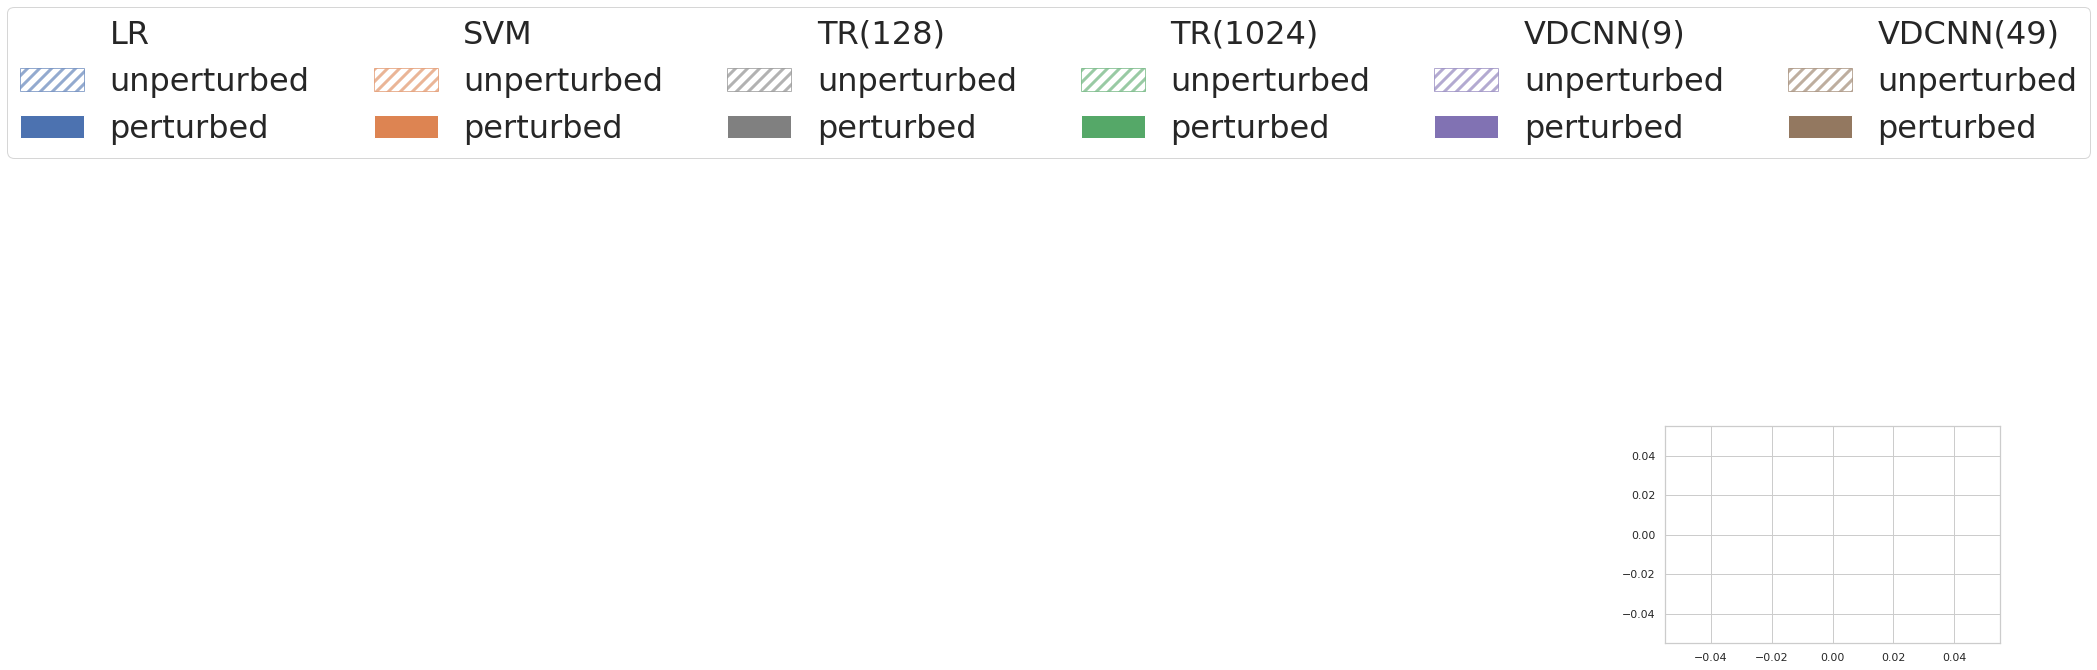

In [7]:
p5, = plot([0], marker='None',
           linestyle='None', label='dummy-tophead')


leg3 = legend([p5, lr_unperturbed_bar, lr_perturbed_bar, 
               p5, svm_unperturbed_bar, svm_perturbed_bar, 
               p5, tr128_unperturbed_bar, tr128_perturbed_bar,
              p5, tr1024_unperturbed_bar, tr1024_perturbed_bar,
               p5, cnn9_unperturbed_bar, cnn9_perturbed_bar,
              p5, cnn49_unperturbed_bar, cnn49_perturbed_bar], 
              ['LR'] + categories + ['SVM'] + categories + ['TR(128)'] + categories + ['TR(1024)'] + categories + ['VDCNN(9)'] + categories + ['VDCNN(49)'] + categories,
              loc=2, ncol=6, fontsize = font_size, bbox_to_anchor=(-5,3)) # Two columns, vertical group labels

leg3.set_rasterized(True)
circ1 = mpatches.Patch( facecolor="black",alpha=0.5,hatch=r'//',label='Label1')
plt.savefig(path3 + "/perturbed_legend.eps",  bbox_inches='tight', format = "eps")
plt.savefig(path4 + "/perturbed_legend.png",  bbox_inches='tight', dpi = my_dpi)